## setup and resources

### imports

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from rna_secstruct_design.selection import get_selection, SecStruct

from qmap_paper.plotting import (
    plot_pop_avg_from_row, find_stretches, fill_between, plot_pop_avg)

from qmap_paper.data_processing import get_dms_reactivity_for_sub_structure, SequenceStructure


# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
# to fight the theme
plt.rcParams["figure.facecolor"] = "white"

ModuleNotFoundError: No module named 'q_dms_ttr_paper'

In [2]:
DATA_PATH = "../../data/sequencing_runs/"

### load data

In [3]:
df_wt_mg = pd.read_json(f"{DATA_PATH}/processed/wt_mg_titra.json")
df_wt_buff = pd.read_json(f"{DATA_PATH}/processed/wt_buffer_titra.json")
df_mttr6_muts = pd.read_json(f"{DATA_PATH}/processed/mttr6_muts_titra.json")
df_mttr6_full = pd.read_json(f"{DATA_PATH}/processed/mttr6_data_full.json")
df_mg_1_2 = pd.read_csv(f"{DATA_PATH}/processed/mtt6_data_mg_1_2_final.csv")
df_dg = pd.read_csv(f"{LIB_PATH}/resources/csvs/ttr_mutation_dgs_subset.csv")
df_dg_new = pd.read_csv(f"{LIB_PATH}/resources/csvs/rna_map_dg.csv")

### plots

In [4]:
def plot_buffer_heatmap(df_sub):
    datas = []
    names = []
    for i, row1 in df_sub.iterrows():
        name = row1["buffer"] + "-" + str(row1["buffer_conc"])
        data = [name]
        names.append(name)
        for j, row2 in df_sub.iterrows():
            data.append(
                round(stats.pearsonr(row1["data"], row2["data"])[0] ** 2, 2)
            )
        datas.append(data)
    cols = ["name"]
    cols.extend(names)
    df_heat = pd.DataFrame(datas, columns=cols)
    fig, ax = plt.subplots(figsize=(10, 10), dpi=600)
    g = sns.heatmap(
        (df_heat.set_index("name")),
        annot=True,
        cmap="viridis",
        ax=ax,
        annot_kws={"fontsize": 10},
    )
    # ensure y labels are not rotated!
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

In [5]:
# style functions
def publication_style_ax(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(width=2)
    fsize = 24
    ax.xaxis.label.set_fontsize(fsize)
    ax.yaxis.label.set_fontsize(fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize-2)


def publication_scatter(ax, x, y, **kwargs):
    ax.scatter(x, y, s=150, **kwargs)


def publication_line(ax, x, y, **kwargs):
    ax.plot(x, y, markersize=10, lw=2, **kwargs)

def r2(x, y):
    return round(stats.pearsonr(x, y)[0] ** 2, 3)

def generate_pymol_file(data, pymol_data_file):
    """
    generate the pymol file for a single row
    """
    with open(pymol_data_file, "w") as f:
        for i, d in enumerate(data):
            d = d*25
            f.write(f"{i+1} {d} {d}\n")


## actual plots

### OLD: Supplemental Figure 5: Comparison of buffer conditions for DMS-MaPseq

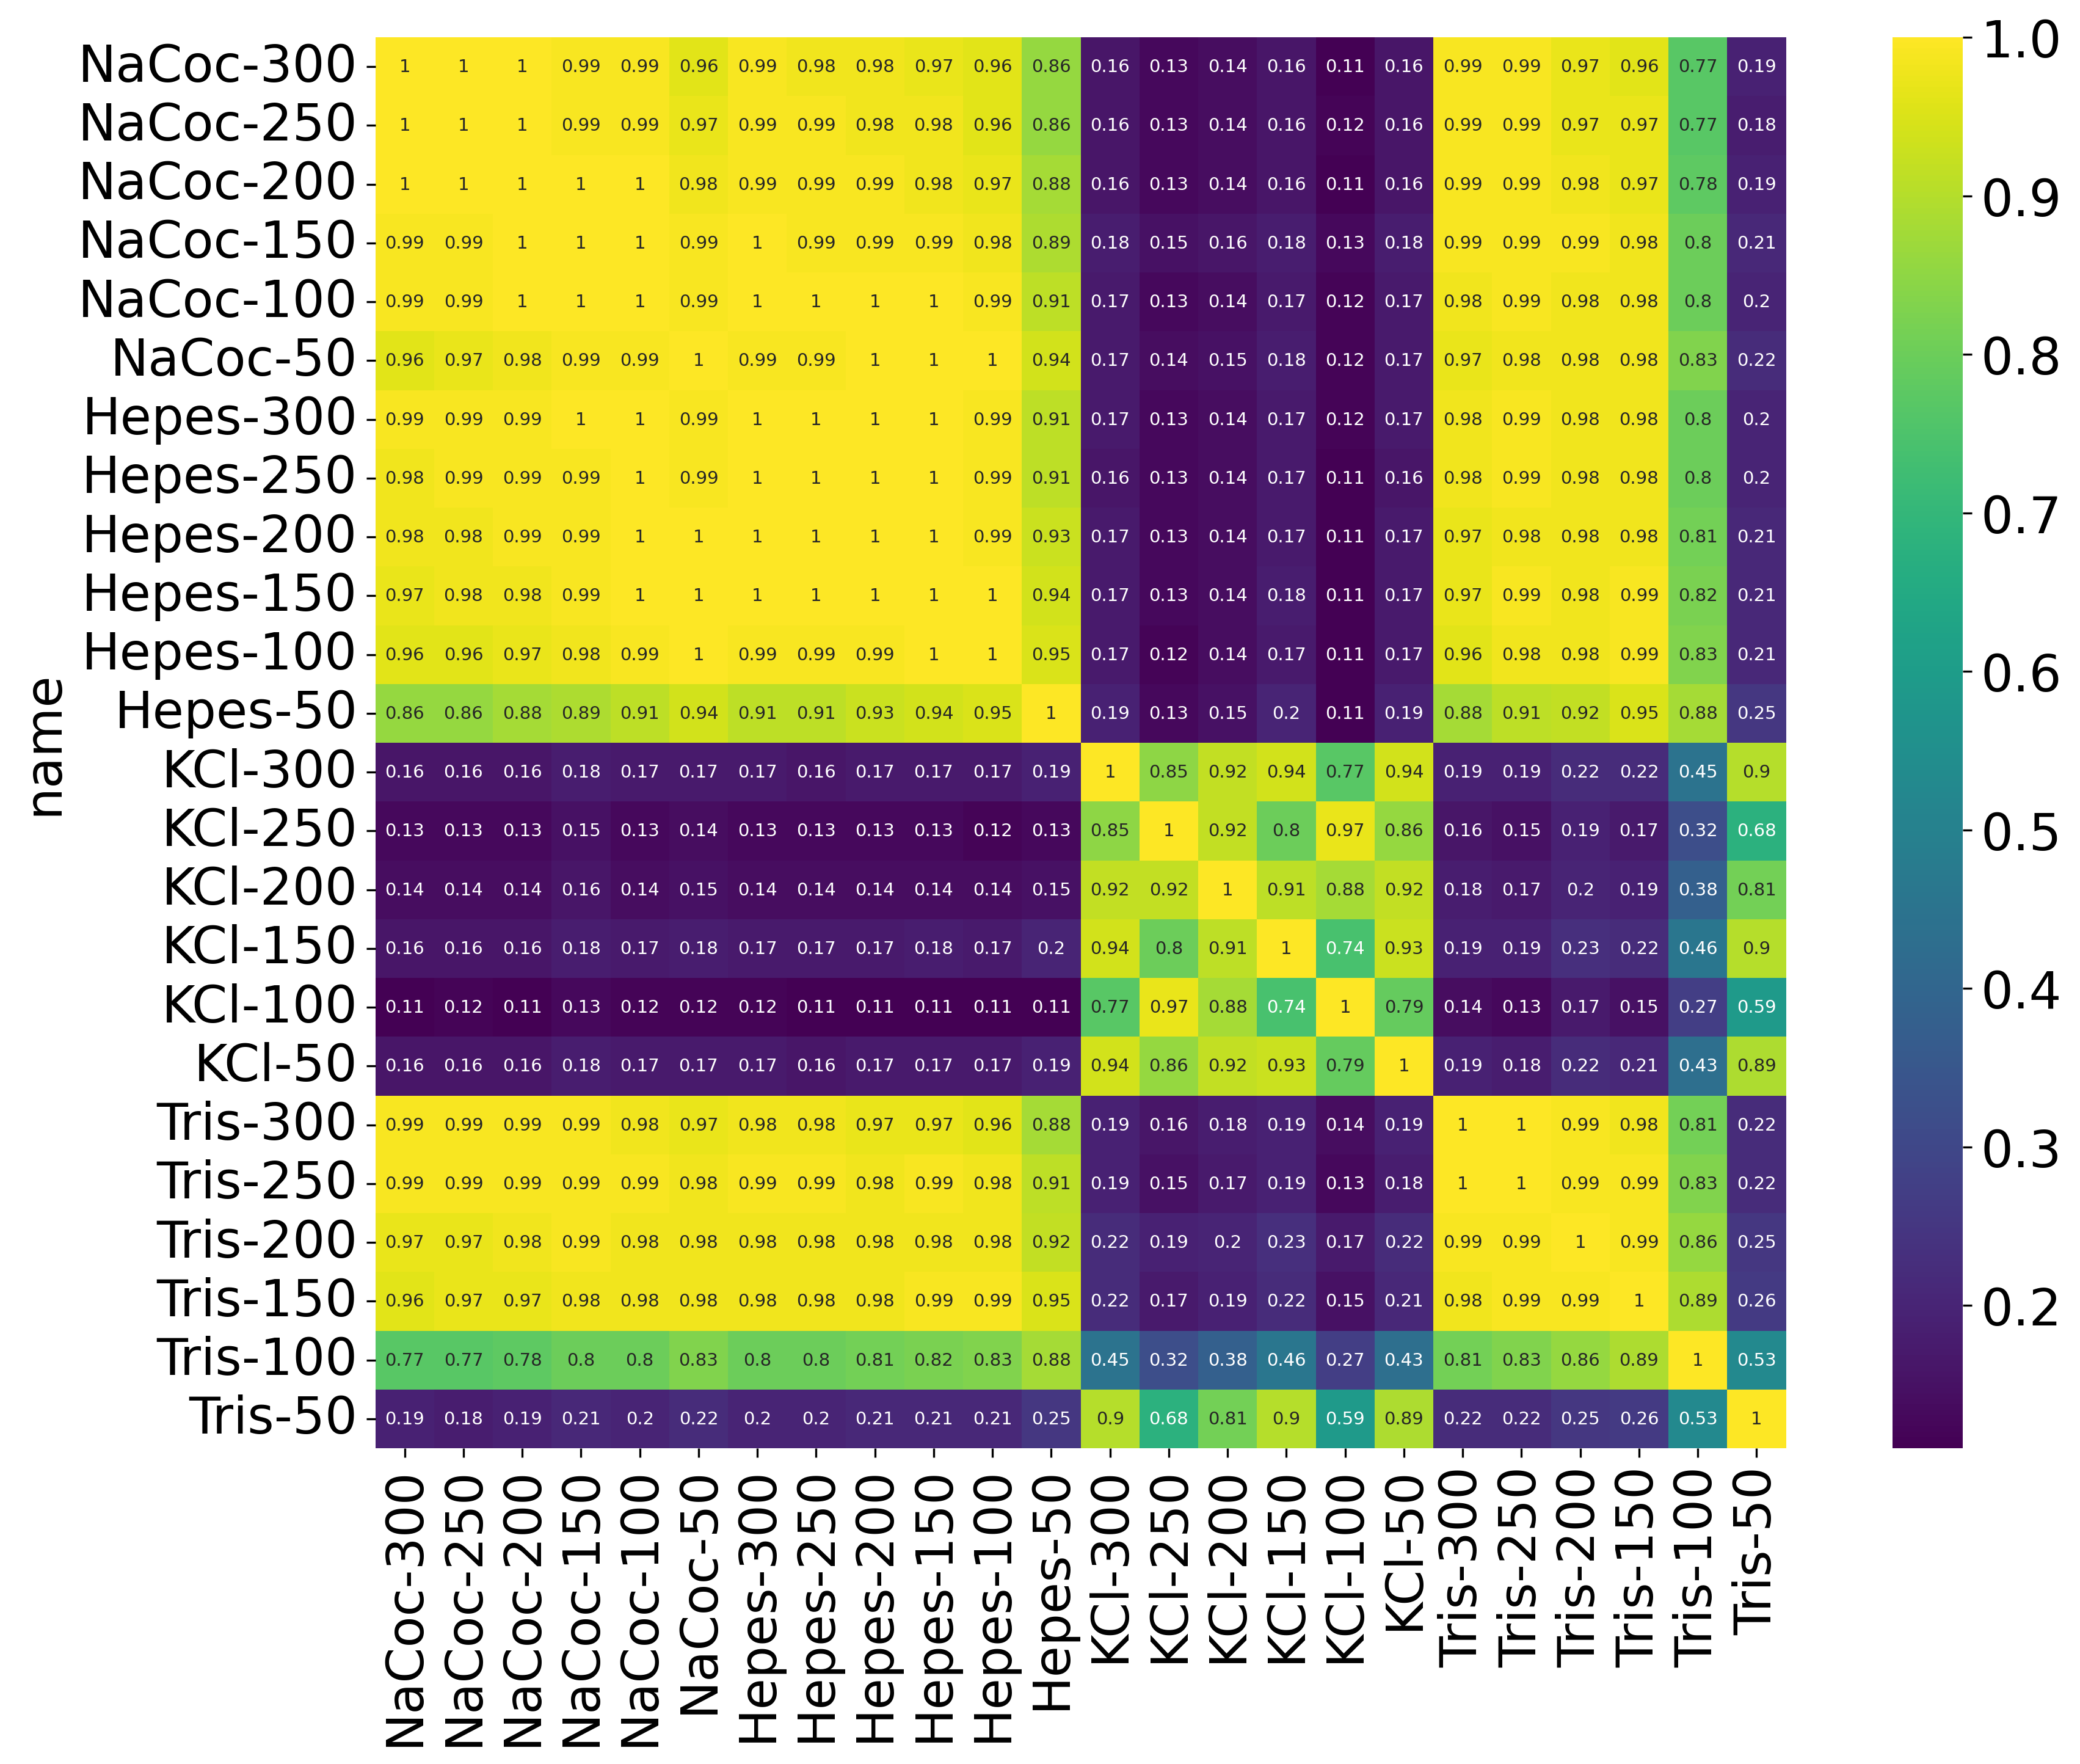

In [6]:
exp_names = [
    "2022_07_25_C0117_NaC_Hep_titra_CM_BL",
    "2022_07_26_C0117_KCl_Tris_titra_CM_BL",
]
dfs = []
for exp in exp_names:
    df_sub = df_wt_buff[df_wt_buff.exp_name == exp]
    dfs.append(df_sub)
df_sub = pd.concat(dfs)
datas = []
names = []
for i, row1 in df_sub.iterrows():
    name = row1['buffer'] + "-" + str(row1['buffer_conc'])
    data = [name]
    names.append(name)
    for j, row2 in df_sub.iterrows():
        data.append(round(stats.pearsonr(row1['data'], row2['data'])[0] ** 2, 2))
    datas.append(data)
cols = ['name']
cols.extend(names)
df_heat = pd.DataFrame(datas, columns=cols)
fig, ax = plt.subplots(dpi=300) 
g = sns.heatmap(
    (df_heat
     .set_index('name')), annot=True, cmap='viridis', ax=ax, annot_kws={"fontsize":7})
ax.set_aspect('equal')

### Supplemental Figure 6:  

In [7]:
df_wt_mg["df_type"] = "df_wt_mg"
df_wt_buff["df_type"] = "df_wt_buff"
df_mttr6_muts["df_type"] = "df_mttr6_muts"
df_all = pd.concat([df_wt_mg, df_wt_buff, df_mttr6_muts])
# print all unique combos between run_name and exp_name
df_all.groupby(['df_type', 'run_name', 'exp_name', 'name']).count()

sequence  \
df_type       run_name                                 exp_name                                       name                                      
df_mttr6_muts 2023_02_02_minittr_6_uucg_Mg_titra_seq   2023_01_30_C013S_50mM_NaC_Mg_titra_CM          minittr_6_uucg_fixed                 16   
              2023_02_17_no_3_3_junc_Mg_titr_seq       2023_02_09_C013V_50mM_NaC_Mg_titra_CM          minittr_6_no_3_3_junc_fixed          16   
              2023_03_10_h1_3bp_longer_seq             2023_03_06_C013W_50mM_NaC_Mg_titra_CM          minittr_6_h1_3bp_longer_fixed        16   
              2023_03_13_no_tlr_Mg_titra_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_tlr_fixed               16   
              2023_03_14_no_ires_Mg_titr_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_ires_fixed              16   
              2023_03_15_h2_3bp_longer_Mg_titra_seq    2023_03_14_C013X_50mM_NaC_Mg_titra_CM          minittr_6_h2_3bp_longer_fixed        16   
              2023_03_22_h3_3bp_longer_Mg_titra_seq    2023_03_07_C013Y_50mM_NaC_Mg_titra_CM          minittr_6_h3_3bp_longer_fixed        16   
df_wt_buff    2022_07_20_minittr_Hepes-titra_seq       2022_07_18_C0117_100mM_buffer_Mg2+_titra_CM_BL minittr-6-2HP-ref                     8   
              2022_07_26_minittr-6-2HP-ref_buffer_seq  2022_07_25_C0117_NaC_Hep_titra_CM_BL           minittr-6-2HP-ref                    12   
                                                       2022_07_26_C0117_KCl_Tris_titra_CM_BL          minittr-6-2HP-ref                    12   
df_wt_mg      2022_07_27_minittr_50mM_NaC_Mg_titra_seq 2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM        minittr-6-2HP-ref                    15   
              2022_07_28_minittr_0.1M_NaC_Mg_titra_seq 2022_07_28_C0117_100mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_07_29_minittr_0.15M_NaC_Mg_titr_seq 2022_07_29_C0117_150mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_08_09_minittr_0.2M_NaC_Mg_titra_seq 2022_08_08_C0117_200mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_08_10_minittr_0.25M_NaC_Mg_titr_seq 2022_08_09_C0117_250mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   
              2022_08_11_minittr_0.3M_NaC_Mg_titra_seq 2022_08_10_C0117_300mM_NaC_Mg_titra_CM         minittr-6-2HP-ref                    16   

                                                                                                                                     structure  \
df_type       run_name                                 exp_name                                       name                                       
df_mttr6_muts 2023_02_02_minittr_6_uucg_Mg_titra_seq   2023_01_30_C013S_50mM_NaC_Mg_titra_CM          minittr_6_uucg_fixed                  16   
              2023_02_17_no_3_3_junc_Mg_titr_seq       2023_02_09_C013V_50mM_NaC_Mg_titra_CM          minittr_6_no_3_3_junc_fixed           16   
              2023_03_10_h1_3bp_longer_seq             2023_03_06_C013W_50mM_NaC_Mg_titra_CM          minittr_6_h1_3bp_longer_fixed         16   
              2023_03_13_no_tlr_Mg_titra_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_tlr_fixed                16   
              2023_03_14_no_ires_Mg_titr_redo_seq      2023_03_13_C013U_50mM_NaC_Mg_titra_redone_CM   minittr_6_no_ires_fixed               16   
              2023_03_15_h2_3bp_longer_Mg_titra_seq    2023_03_14_C013X_50mM_NaC_Mg_titra_CM          minittr_6_h2_3bp_longer_fixed         16   
              2023_03_22_h3_3bp_longer_Mg_titra_seq    2023_03_07_C013Y_50mM_NaC_Mg_titra_CM          minittr_6_h3_3bp_longer_fixed         16   
df_wt_buff    2022_07_20_minittr_Hepes-titra_seq       2022_07_18_C0117_100mM_buffer_Mg2+_titra_CM_BL minittr-6-2HP-ref                      8   
              2022_07_26_minittr-6-2HP-ref_buffer_seq  2022_07

In [8]:
wt_w_o_mg = df_wt_mg[(df_wt_mg.mg_conc == 0) & (df_wt_mg.exp_name == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM")].iloc[0]
uucg_w_o_mg = df_mttr6_muts[(df_mttr6_muts.mg_conc == 0) & (df_mttr6_muts.name == "minittr_6_uucg_fixed")].iloc[0]
no_tlr_w_o_mg = df_mttr6_muts[(df_mttr6_muts.mg_conc == 0) & (df_mttr6_muts.name == "minittr_6_no_tlr_fixed")].iloc[0]


In [9]:
# how to do highlights
def get_highlight_bounds(sequence, structure, highlights):
    highlight_bounds = []
    secstruct = SecStruct(sequence, structure)
    for h in highlights:
        selection = get_selection(secstruct, h)
        for bounds in find_stretches(selection):
            highlight_bounds.append(bounds)
    return highlight_bounds

(-4.0, 94.0)

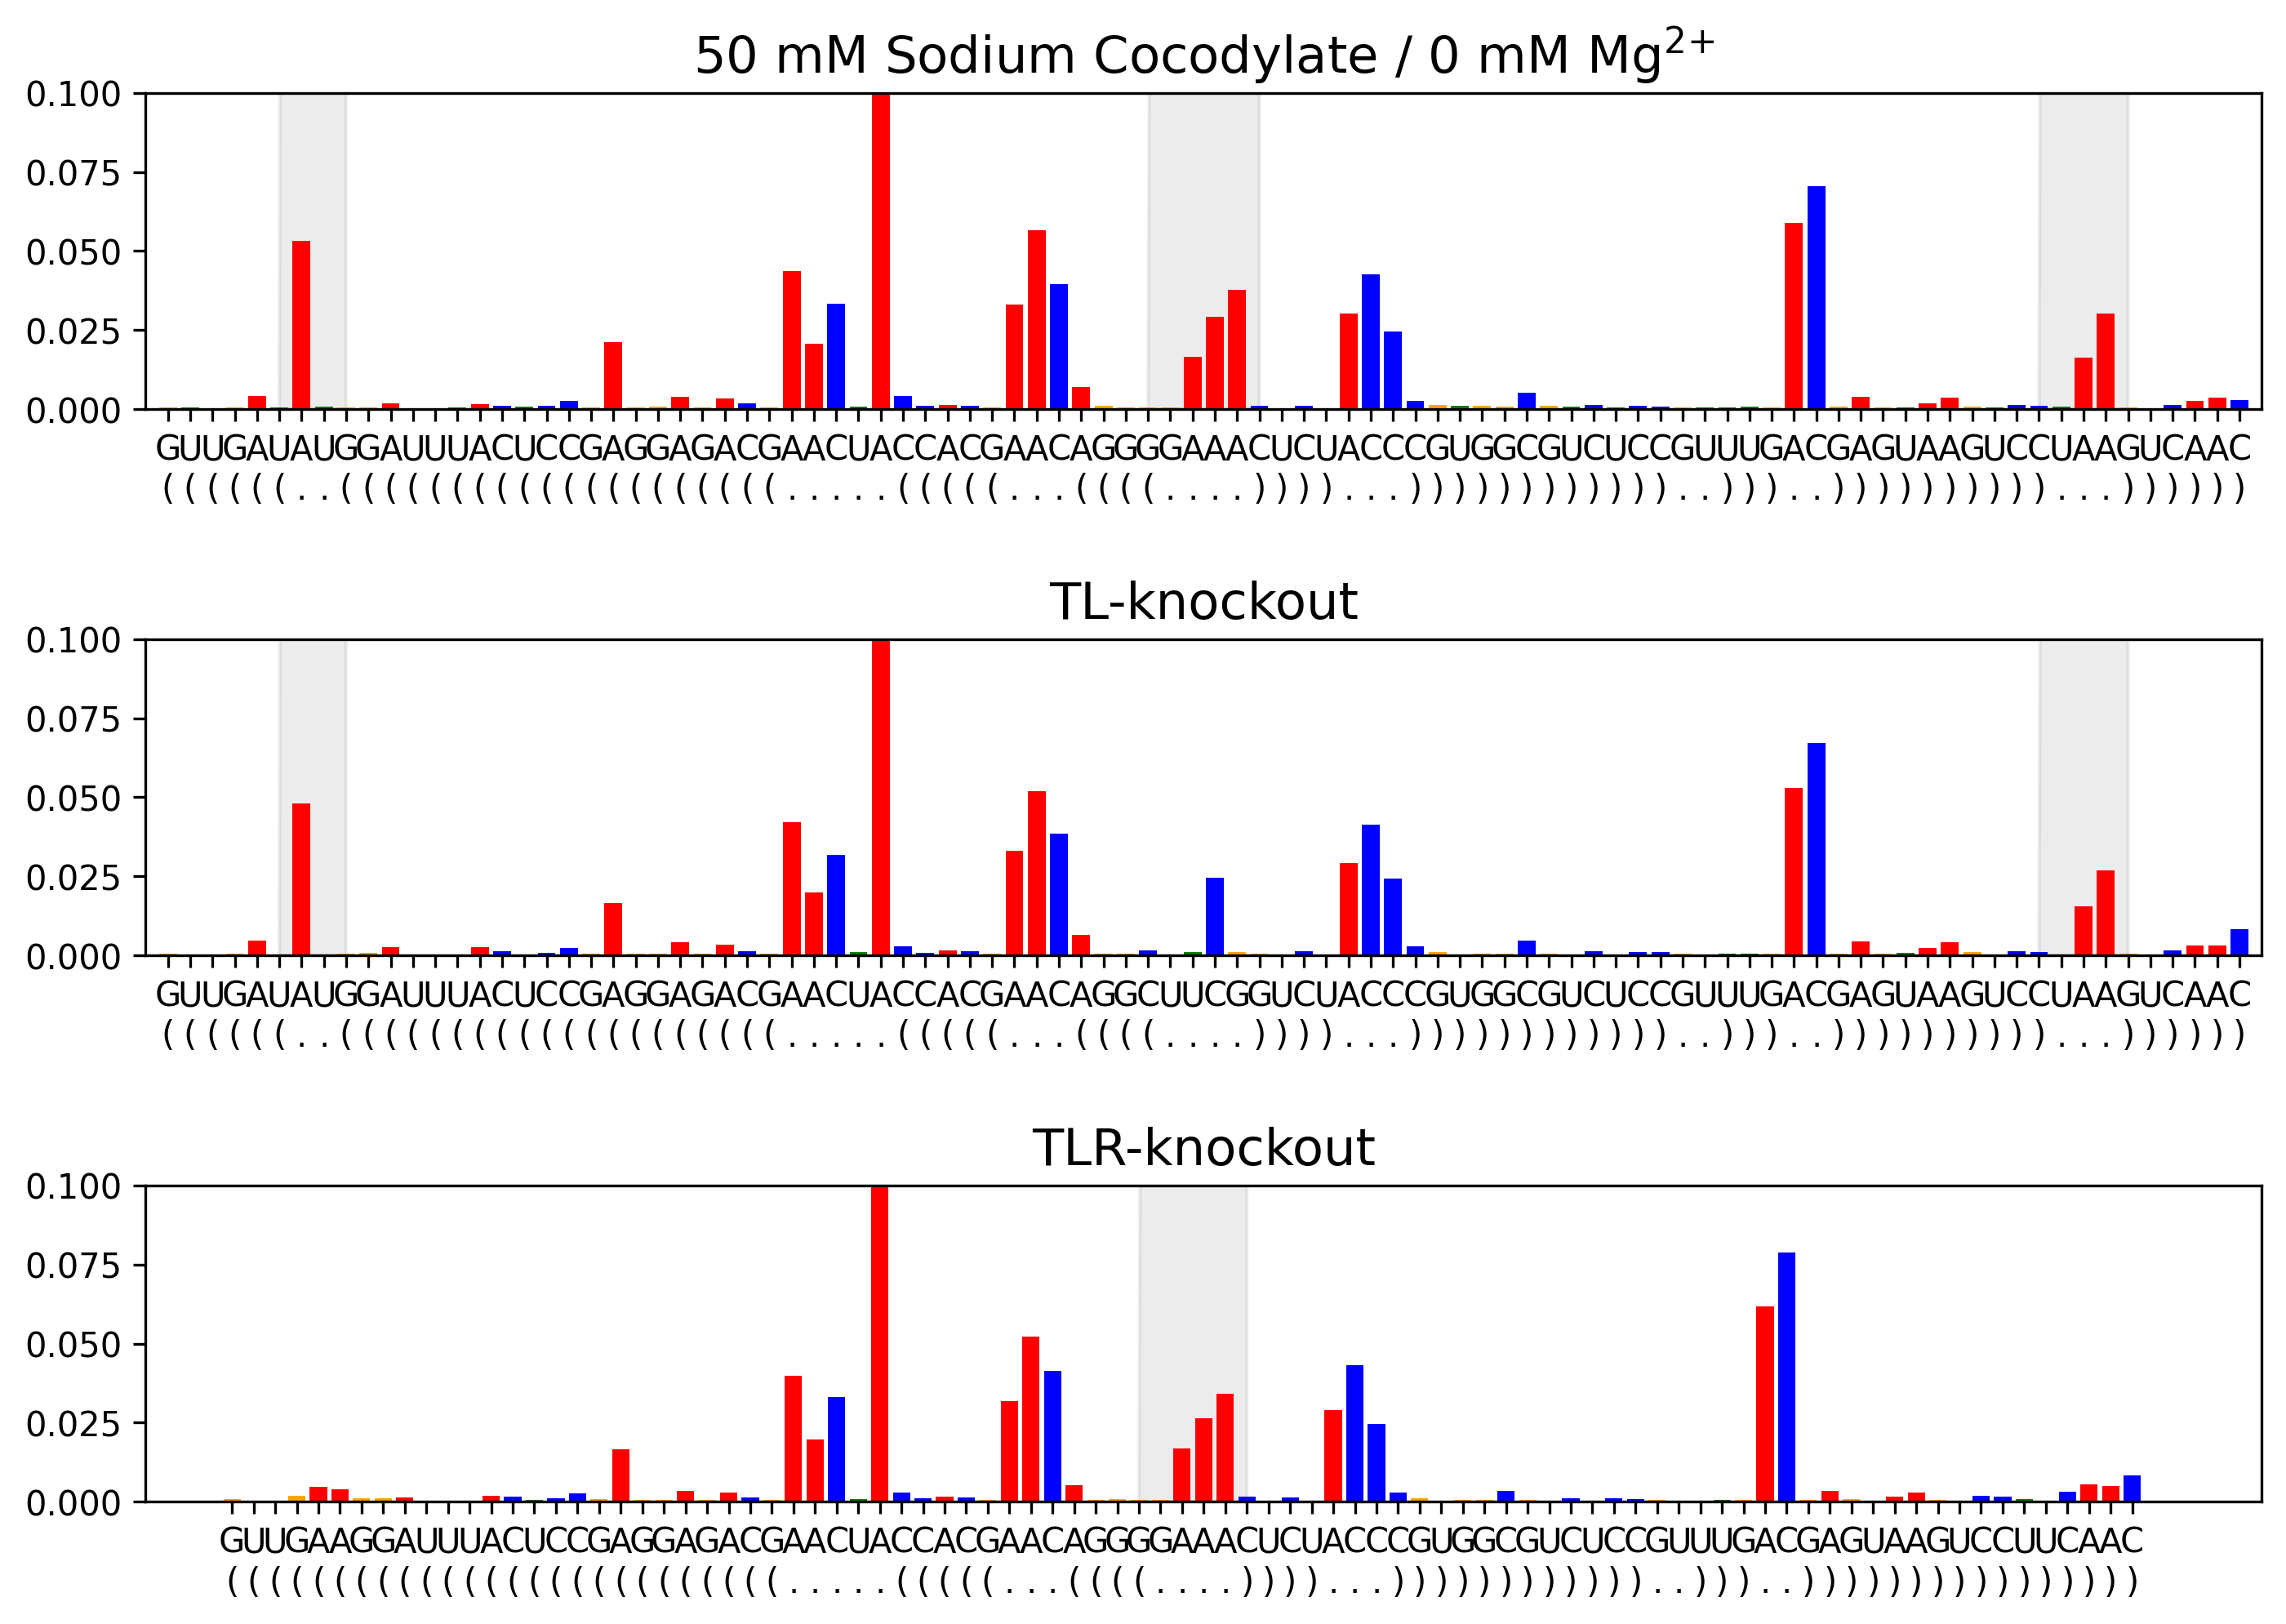

In [10]:
highlights = []
highlights.append({"motif": {"name": "gaaa_tetraloop"}})
highlights.append({"motif": {"name": "tlr"}})
fig, axes = plt.subplots(3, 1, figsize=(10, 7), dpi=300)
plot_pop_avg(wt_w_o_mg["sequence"], wt_w_o_mg["structure"], wt_w_o_mg["data"], ax=axes[0], 
             trim_5p=20, trim_3p=22, highlights=highlights)
axes[0].set_title("50 mM Sodium Cocodylate / 0 mM Mg$^{2\!+}\!$", fontsize=15)
axes[0].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[0].set_ylim([0, 0.1])
axes[0].set_xlim([-1, len(wt_w_o_mg["sequence"]) - 22 - 20])
plot_pop_avg(uucg_w_o_mg["sequence"], uucg_w_o_mg["structure"], uucg_w_o_mg["data"], 
             ax=axes[1], trim_5p=20, trim_3p=0, highlights=[highlights[1]])
axes[1].set_title("TL-knockout", fontsize=15)
axes[1].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[1].set_ylim([0, 0.1])
axes[1].set_xlim([-1, len(uucg_w_o_mg["sequence"]) - 20])
fig.tight_layout()
plot_pop_avg(no_tlr_w_o_mg["sequence"], no_tlr_w_o_mg["structure"], no_tlr_w_o_mg["data"], 
             ax=axes[2], trim_5p=20, trim_3p=0, highlights=[highlights[0]])
axes[2].set_title("TLR-knockout", fontsize=15)
axes[2].set_ylim([0, 0.1])
axes[2].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[2].set_ylim([0, 0.1])
axes[2].set_xlim([-4, len(uucg_w_o_mg["sequence"]) - 20])
#plt.savefig(f"supplemental_figure_6.pdf", bbox_inches='tight')


### Supplemental Figure 8

In [11]:
def get_motif_data(df_wt, df_uucg, motif_name, motif_seq, motif_ss):
    data = []
    for i, row in df_wt.iterrows():
        count = 1
        uucg_row = df_uucg[df_uucg["mg_conc"] == row["mg_conc"]].iloc[0]
        for seq, ss, wt_val, uucg_val in zip(
            motif_seq, motif_ss, row[motif_name], uucg_row[motif_name]
        ):
            if seq != "A" and seq != "C":
                continue
            data.append(
                {
                    "name": str(count) + seq,
                    "seq": seq,
                    "ss": ss,
                    "wt_val": wt_val,
                    "wt_norm": wt_val / row["ref_hp_1_as"],
                    "uucg_val": uucg_val,
                    "uucg_norm": uucg_val / uucg_row["ref_hp_1_as"],
                    "mg_conc": row["mg_conc"],
                }
            )
            count += 1
    df = pd.DataFrame(data)
    return df

In [12]:
df_wt = df_wt_mg[df_wt_mg["exp_name"] == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM"]
df_uucg = df_mttr6_muts[df_mttr6_muts["name"] == "minittr_6_uucg_fixed"]
df_uucg = df_uucg.sort_values("mg_conc")


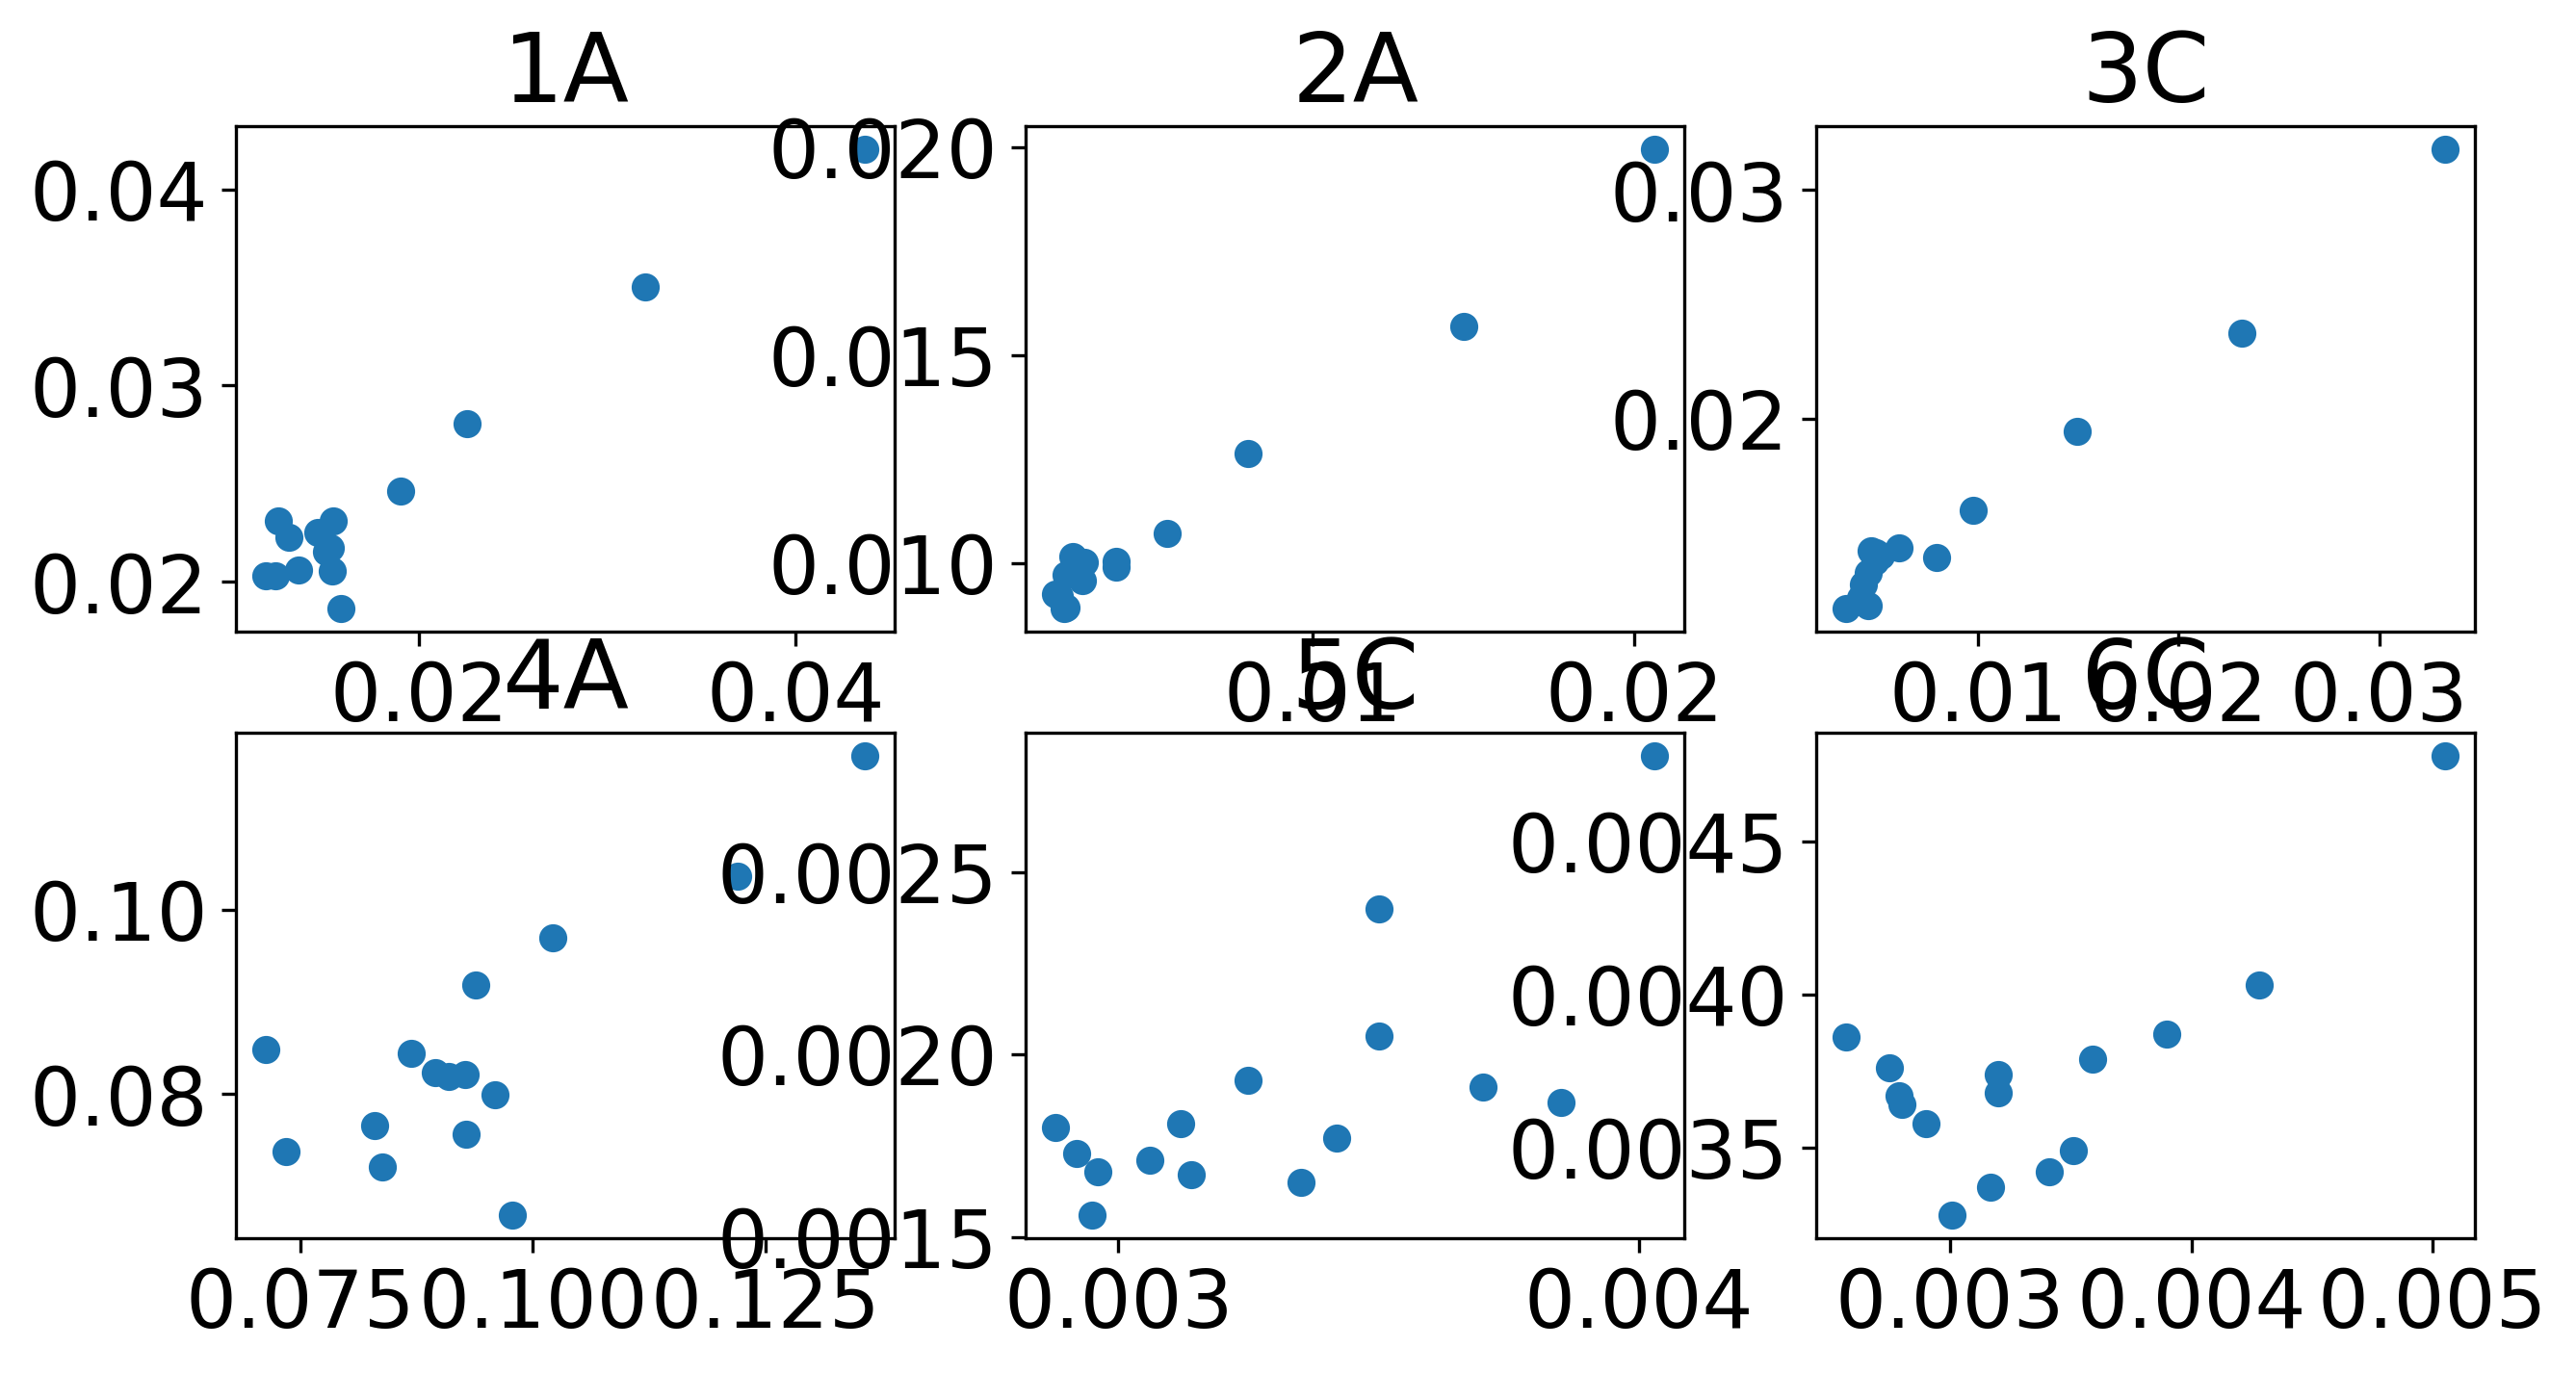

In [13]:
 # ires
sequence = "GAACUACGC"
structure = "(.....())"
fig, axes = plt.subplots(2, 3, figsize=(10, 5), dpi=300)
axes = axes.flatten()
df_motif = get_motif_data(df_wt, df_uucg, "ires", sequence, structure)
for i, (name, g) in enumerate(df_motif.groupby("name")):
    axes[i].set_title(name)
    axes[i].scatter(g["wt_val"], g["uucg_val"])



### Supplemental Figure 19

In [14]:
exclude = [
    "CAUGA_UCUAAA",
    "UACGG_CCUACA",
    "UAUGG_CUUAAC",
    "CACGG_CCUCAC",
    "CAUGC_GCUCAA",
    "CAUGC_GCUGAA",
    "CAUGG_CCUCAA",
    "CAUGG_CCUGAA",
    "UAAGG_CCUAAAG",
    "UAGGG_CCUAAC",
    "UAUGG_CCUCAC",
]

def r2(x, y):
    return round(stats.pearsonr(x, y)[0] ** 2, 3)

def plot_correlation_at_mg_conc(df, mg_conc):
    df_sub_mg = df[df["mg_conc"] == mg_conc]
    fig, ax = plt.subplots()
    df_sub_mg = df_sub_mg[~df_sub_mg["name"].isin(exclude)]
    df_sub_mg.merge(df_dg, on="name")
    df_sub_mg["ln_gaaa_avg"] = np.log(df_sub_mg["gaaa_avg"])
    sns.regplot(x="dg", y="ln_gaaa_avg", data=df_sub_mg, ax=ax, scatter_kws={"s": 75}, line_kws={"lw" : 3})
    ax.set_box_aspect(1)
    ax.set_xlabel("dG (kcal/mol)")
    ax.set_ylabel("ln GAAA reactivity")
    publication_style_ax(ax)
    return r2(df_sub_mg["dg"], df_sub_mg["ln_gaaa_avg"])
    

In [15]:
print(sorted(df_mttr6_full["mg_conc"].unique()))

[0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 3.5, 5.0, 6.5, 7.5, 10.0, 15.0, 20.0, 40.0]


0.615


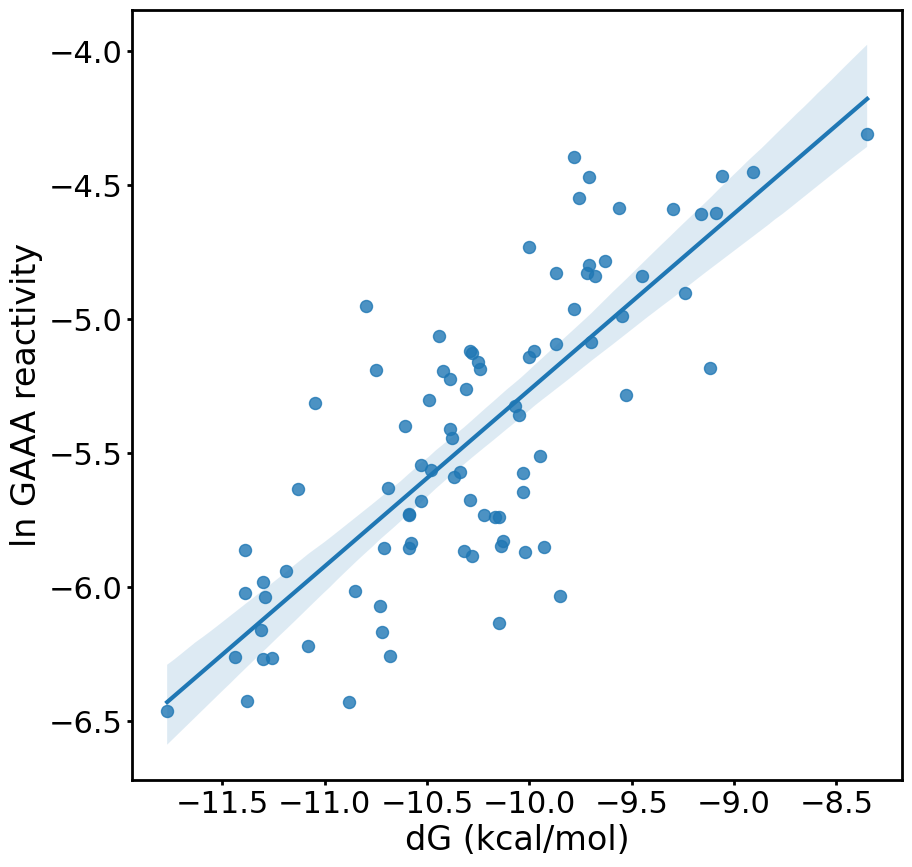

In [16]:
r2_val = plot_correlation_at_mg_conc(df_mttr6_full, 40.0)
print(r2_val)



### Supplemental Figure 20


Text(0, 0.5, 'Mutation Fraction')

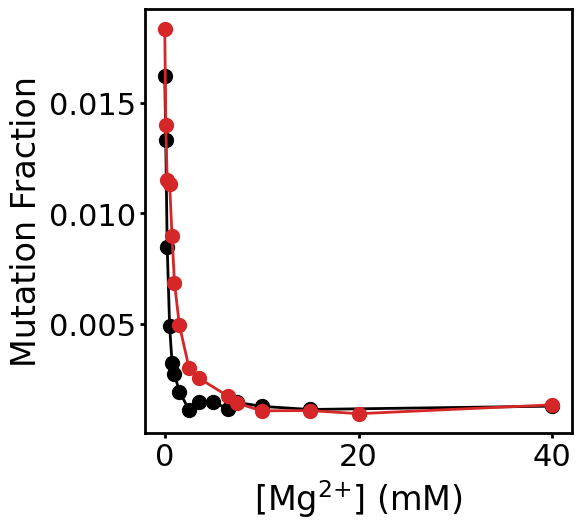

In [17]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_CAUGG_CCUAAC = df_mttr6_full[df_mttr6_full["name"] == "CAUGG_CCUAAC"]
df_CAUGG_CCUAAC = df_CAUGG_CCUAAC[df_CAUGG_CCUAAC["mg_conc"] != 5.0]
POS = 4
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black', label='WT')
publication_line(ax, df_CAUGG_CCUAAC['mg_conc'], df_CAUGG_CCUAAC['tlr'].apply(lambda x : x[POS-1]), marker='o', markerfacecolor='tab:red', color='tab:red', label="CCUAAC_CAUGG")
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")


Text(0, 0.5, 'Mutation Fraction')

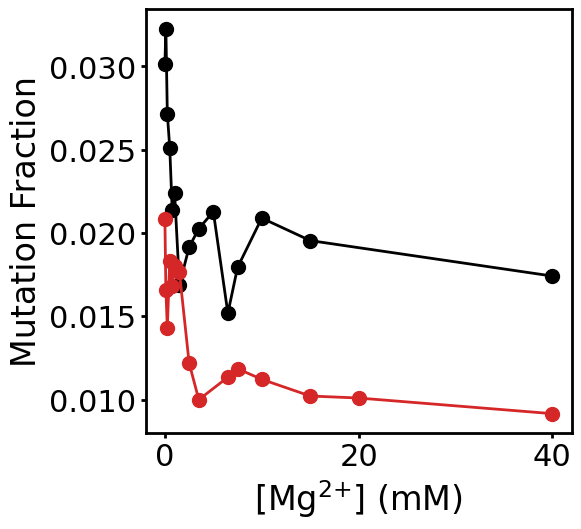

In [18]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_CAUGG_CCUAAC = df_mttr6_full[df_mttr6_full["name"] == "CAUGG_CCUAAC"]
df_CAUGG_CCUAAC = df_CAUGG_CCUAAC[df_CAUGG_CCUAAC["mg_conc"] != 5.0]
POS = 5
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black')
publication_line(ax, df_CAUGG_CCUAAC['mg_conc'], df_CAUGG_CCUAAC['tlr'].apply(lambda x : x[POS-1]), marker='o', markerfacecolor='tab:red', color='tab:red')
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")

Text(0.5, 0, '[Mg$^{2\\!+}\\!$] (mM)')

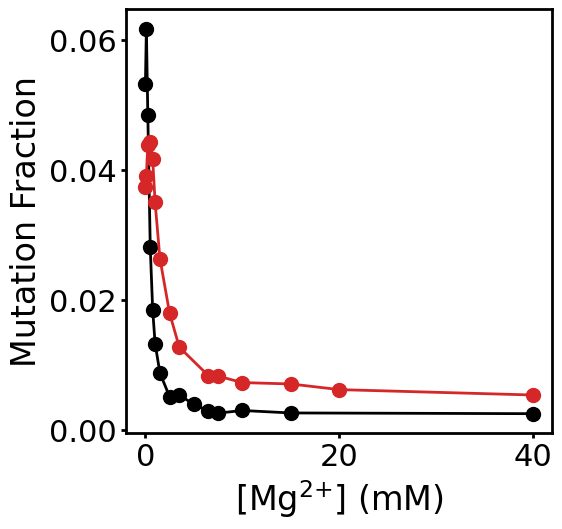

In [19]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_CAUGG_CCUAAC = df_mttr6_full[df_mttr6_full["name"] == "CAUGG_CCUAAC"]
df_CAUGG_CCUAAC = df_CAUGG_CCUAAC[df_CAUGG_CCUAAC["mg_conc"] != 5.0]
POS = 8
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black')
publication_line(ax, df_CAUGG_CCUAAC['mg_conc'], df_CAUGG_CCUAAC['tlr'].apply(lambda x : x[POS-1]), marker='o', markerfacecolor='tab:red', color='tab:red')
ax.set_ylabel("Mutation Fraction")
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")


### Supplemental Figure 21


In [20]:
wt_w_o_mg = df_wt_mg[(df_wt_mg.mg_conc == 0) & (df_wt_mg.exp_name == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM")].iloc[0]
wt_w_mg = df_wt_mg[(df_wt_mg.mg_conc == 40) & (df_wt_mg.exp_name == "2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM")].iloc[0]


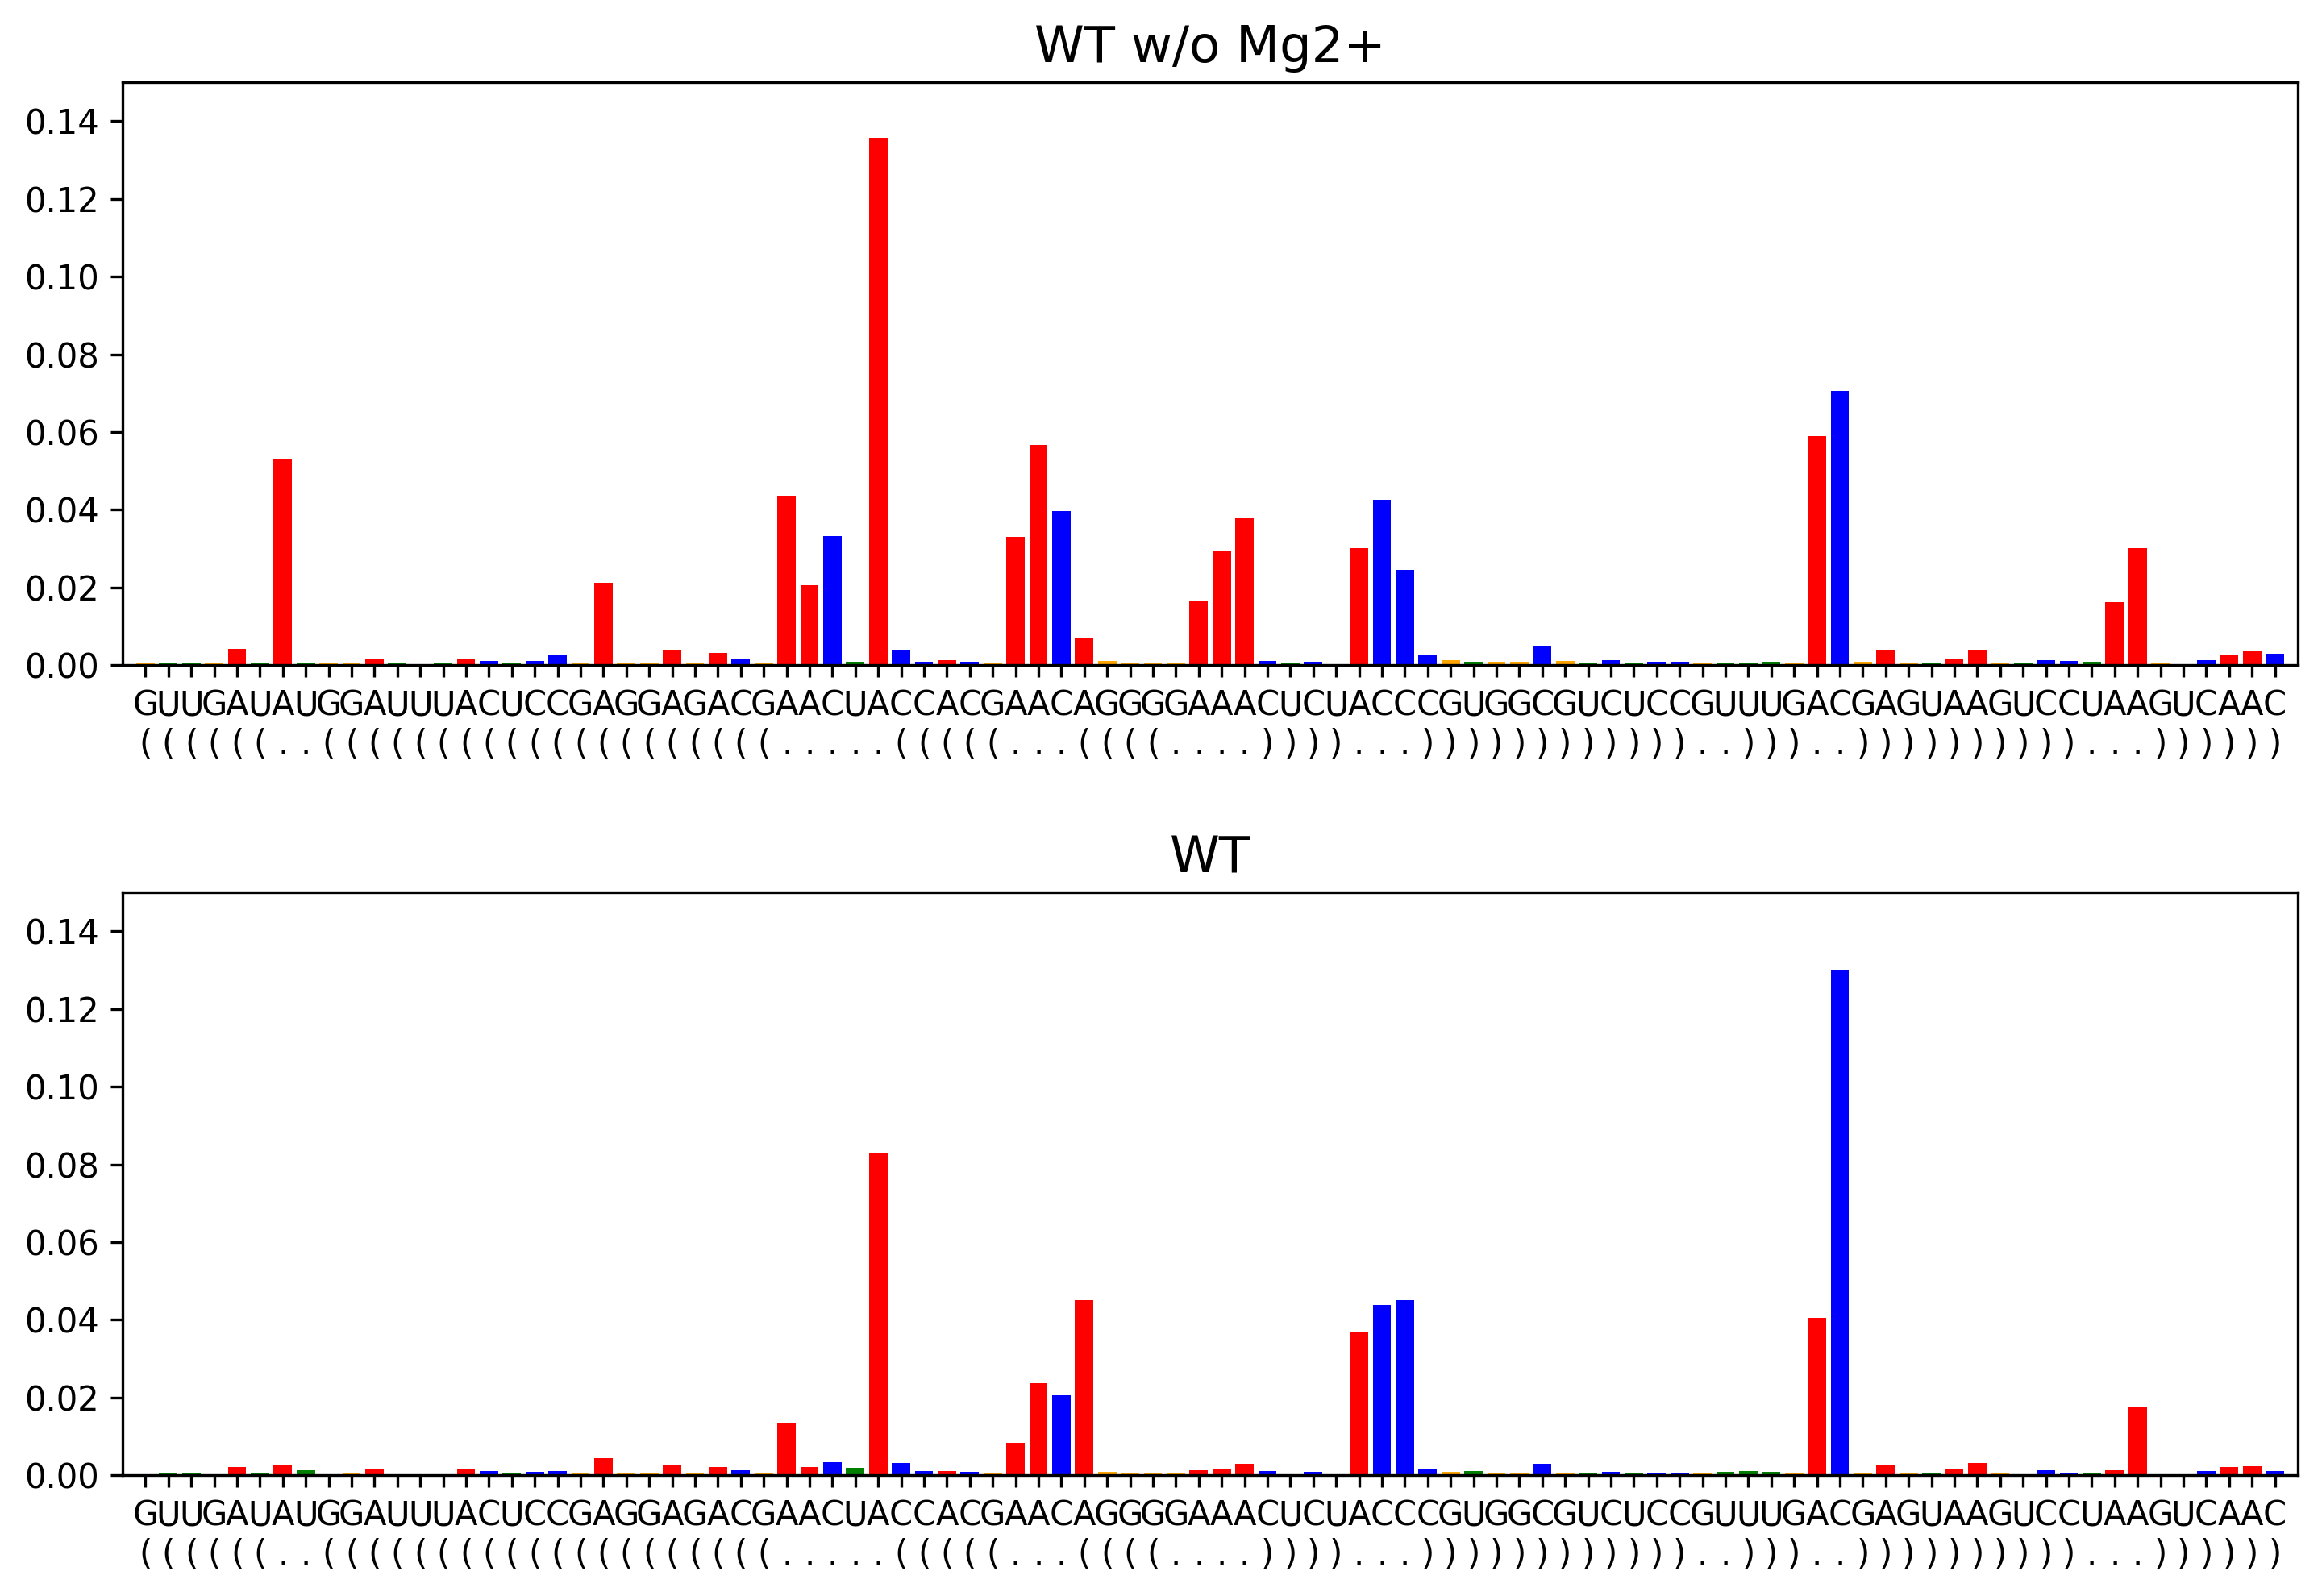

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), dpi=300)
plot_pop_avg(wt_w_o_mg["sequence"], wt_w_o_mg["structure"], wt_w_o_mg["data"], ax=axes[0], 
             trim_5p=20, trim_3p=22)
axes[0].set_title("WT w/o Mg2+", fontsize=15)
axes[0].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[0].set_ylim([0, 0.15])
axes[0].set_xlim([-1, len(wt_w_o_mg["sequence"]) - 22 - 20])
plot_pop_avg(wt_w_mg["sequence"], wt_w_mg["structure"], wt_w_mg["data"], 
             ax=axes[1], trim_5p=20, trim_3p=22)
axes[1].set_title("WT", fontsize=15)
axes[1].tick_params(axis='both', labelsize=10)  # Adjusts both x and y tick labels
axes[1].set_ylim([0, 0.15])
axes[1].set_xlim([-1, len(uucg_w_o_mg["sequence"]) - 20])
fig.tight_layout()

### supplemental figure 23

(0.0, 0.02)

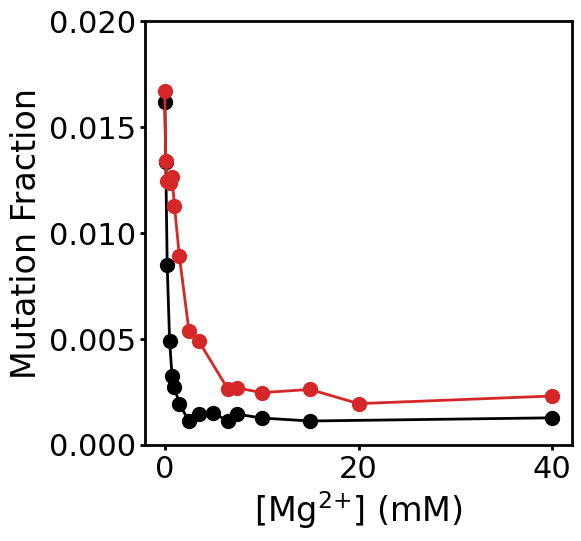

In [22]:
# CCUAAAG_UAUGG
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_UAUGG_CCUAAAG = df_mttr6_full[df_mttr6_full["name"] == "UAUGG_CCUAAAG"]
df_UAUGG_CCUAAAG = df_UAUGG_CCUAAAG[df_UAUGG_CCUAAAG["mg_conc"] != 5.0]
POS = 4
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[POS-1]), marker='o', markerfacecolor='tab:red', color='tab:red')
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")
ax.set_ylim([0, 0.02])

(0.0, 0.04)

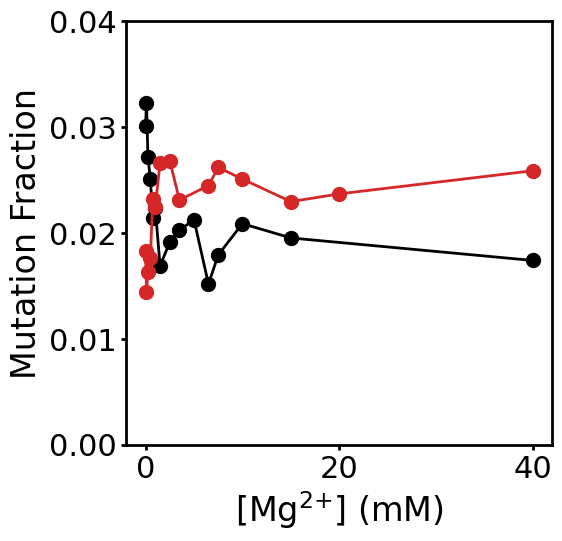

In [23]:
# CCUAAAG_UAUGG
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_UAUGG_CCUAAAG = df_mttr6_full[df_mttr6_full["name"] == "UAUGG_CCUAAAG"]
df_UAUGG_CCUAAAG = df_UAUGG_CCUAAAG[df_UAUGG_CCUAAAG["mg_conc"] != 5.0]
POS = 5
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[POS-1]), marker='o', markerfacecolor='tab:red', color='tab:red')
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")
ax.set_ylim([0, 0.04])

Text(0, 0.5, 'Mutation Fraction')

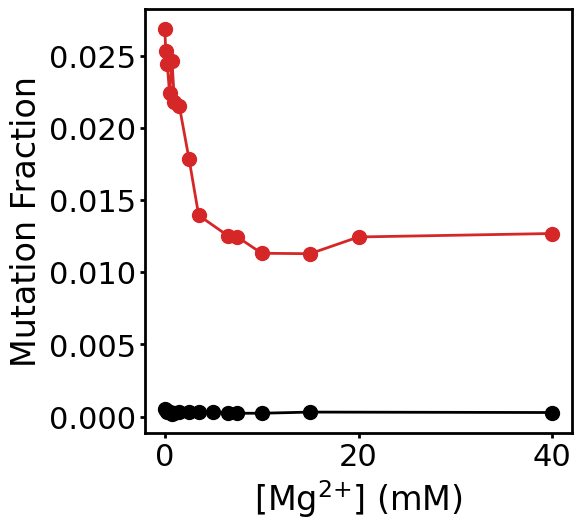

In [24]:
# CCUAAAG_UAUGG
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_UAUGG_CCUAAAG = df_mttr6_full[df_mttr6_full["name"] == "UAUGG_CCUAAAG"]
df_UAUGG_CCUAAAG = df_UAUGG_CCUAAAG[df_UAUGG_CCUAAAG["mg_conc"] != 5.0]
POS = 6
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[POS-1]), marker='o', markerfacecolor='tab:red', color='tab:red')
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")

(0.0, 0.065)

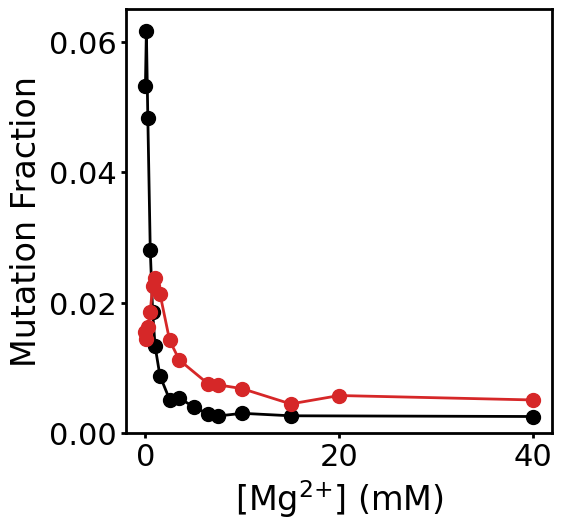

In [25]:
# CCUAAAG_UAUGG
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_UAUGG_CCUAAAG = df_mttr6_full[df_mttr6_full["name"] == "UAUGG_CCUAAAG"]
df_UAUGG_CCUAAAG = df_UAUGG_CCUAAAG[df_UAUGG_CCUAAAG["mg_conc"] != 5.0]
POS = 8
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[POS-1]), marker='o', color='black', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[POS]), marker='o', markerfacecolor='tab:red', color='tab:red')
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")
ax.set_ylim([0, 0.065])

(0.0, 0.065)

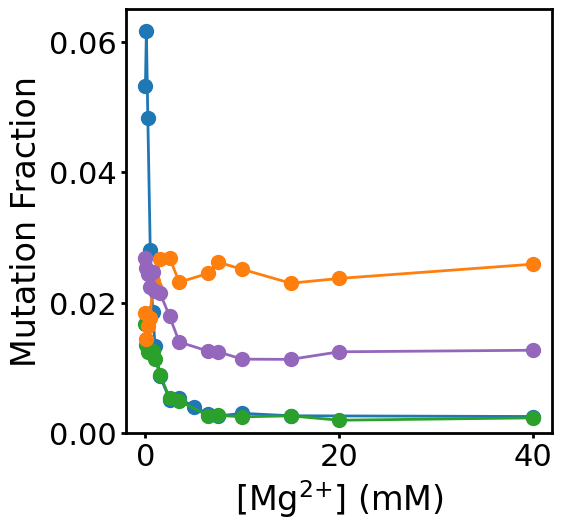

In [26]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
df_UAUGG_CCUAAAG = df_mttr6_full[df_mttr6_full["name"] == "UAUGG_CCUAAAG"]
df_UAUGG_CCUAAAG = df_UAUGG_CCUAAAG[df_UAUGG_CCUAAAG["mg_conc"] != 5.0]
POS = 8
publication_style_ax(ax)
publication_line(ax, df_wt['mg_conc'], df_wt['tlr'].apply(lambda x : x[8-1]), marker='o', color='tab:blue', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[3]), marker='o', color='tab:green', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[4]), marker='o', color='tab:orange', label='WT')
publication_line(ax, df_UAUGG_CCUAAAG['mg_conc'], df_UAUGG_CCUAAAG['tlr'].apply(lambda x : x[5]), marker='o', color='tab:purple', label='WT')
ax.set_xlabel("[Mg$^{2\!+}\!$] (mM)")
ax.set_ylabel("Mutation Fraction")
ax.set_ylim([0, 0.065])

### supplemental figure XXX: compare reactivity for destabilization 

In [27]:
df_mttr6_muts["name"].unique()

array(['minittr_6_no_tlr_fixed', 'minittr_6_uucg_fixed',
       'minittr_6_no_3_3_junc_fixed', 'minittr_6_h1_3bp_longer_fixed',
       'minittr_6_no_ires_fixed', 'minittr_6_h2_3bp_longer_fixed',
       'minittr_6_h3_3bp_longer_fixed'], dtype=object)

Text(0, 0.5, 'GAAA Mutation Fraction')

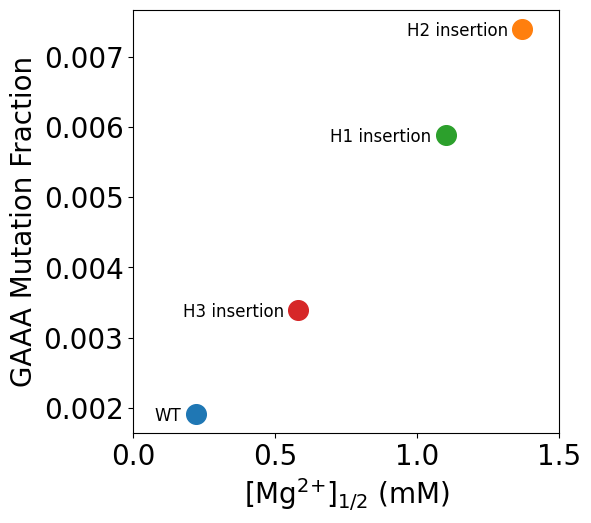

In [28]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
# Your scatter plot data
x_values = [0.22, 1.10, 1.37, 0.58]
y_values = [0.0019166667, 0.0058866667, 0.0073933333, 0.0033966]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
labels = ['WT', 'H1 insertion', 'H2 insertion', 'H3 insertion']  # Replace with your labels

# Create scatter plot
for x, y, c, label in zip(x_values, y_values, colors, labels):
    ax.scatter([x], [y], color=c, s=200)
    ax.text(x-0.05, y-0.00010, label, fontsize=12, ha='right')  # Adjust text properties as needed
ax.set_xlim([0, 1.5])
ax.set_xlabel("[Mg$^{2\!+}\!$]$_{1/2}$ (mM)")
ax.set_ylabel("GAAA Mutation Fraction")

### supplemental figure XXX: using average GAAA instead of each A

In [29]:
df_sub = df_wt_mg[df_wt_mg["buffer_conc"] == 50]


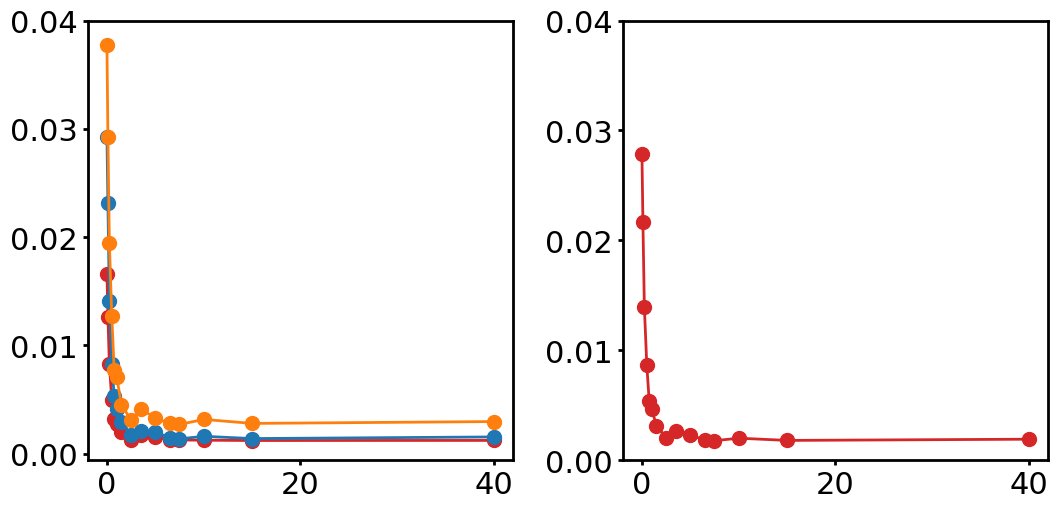

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5.5))
publication_style_ax(ax[0])
publication_line(ax[0], df_sub['mg_conc'], [x[2] for x in df_sub['gaaa']], marker='o', color='tab:red')
publication_line(ax[0], df_sub['mg_conc'], [x[3] for x in df_sub['gaaa']], marker='o', color='tab:blue')
publication_line(ax[0], df_sub['mg_conc'], [x[4] for x in df_sub['gaaa']], marker='o', color='tab:orange')


# averaged
publication_style_ax(ax[1])
publication_line(ax[1], df_sub['mg_conc'], df_sub['gaaa_avg'], marker='o', color='tab:red')

#ax.set_ylabel("Average mutation fraction")
#ax.set_xlabel("Mg    concentration (mM)")
#ax.legend()
ax[0].set_yticks([0.0, 0.01,0.02,0.03,0.04]);
ax[1].set_yticks([0.0, 0.01,0.02,0.03,0.04]);
plt.tight_layout()

### supplemental figure XXX: correlation between Mg2+/2 and GAAA reactivity

In [31]:
exclude = [
    "CAUGA_UCUAAA",
    "UACGG_CCUACA",
    "UAUGG_CUUAAC",
    "CACGG_CCUCAC",
    "CAUGC_GCUCAA",
    "CAUGC_GCUGAA",
    "CAUGG_CCUCAA",
    "CAUGG_CCUGAA",
    "UAAGG_CCUAAAG",
    "UAGGG_CCUAAC",
    "UAUGG_CCUCAC",
]

In [32]:
df_sub = df_mg_1_2[~df_mg_1_2["name"].isin(exclude)].copy()
df_sub = df_sub.merge(df_dg, on="name")
df_sub_mg = df_mttr6_full[df_mttr6_full["mg_conc"] == 7.5]
df_sub_mg["ln_gaaa_avg"] = np.log(df_sub_mg["gaaa_avg"])
df_sub = df_sub.merge(df_sub_mg, on="name")
df_sub = df_sub[df_sub["mg_1_2"] < 10]
len(df_sub)

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/248407272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_mg["ln_gaaa_avg"] = np.log(df_sub_mg["gaaa_avg"])


84

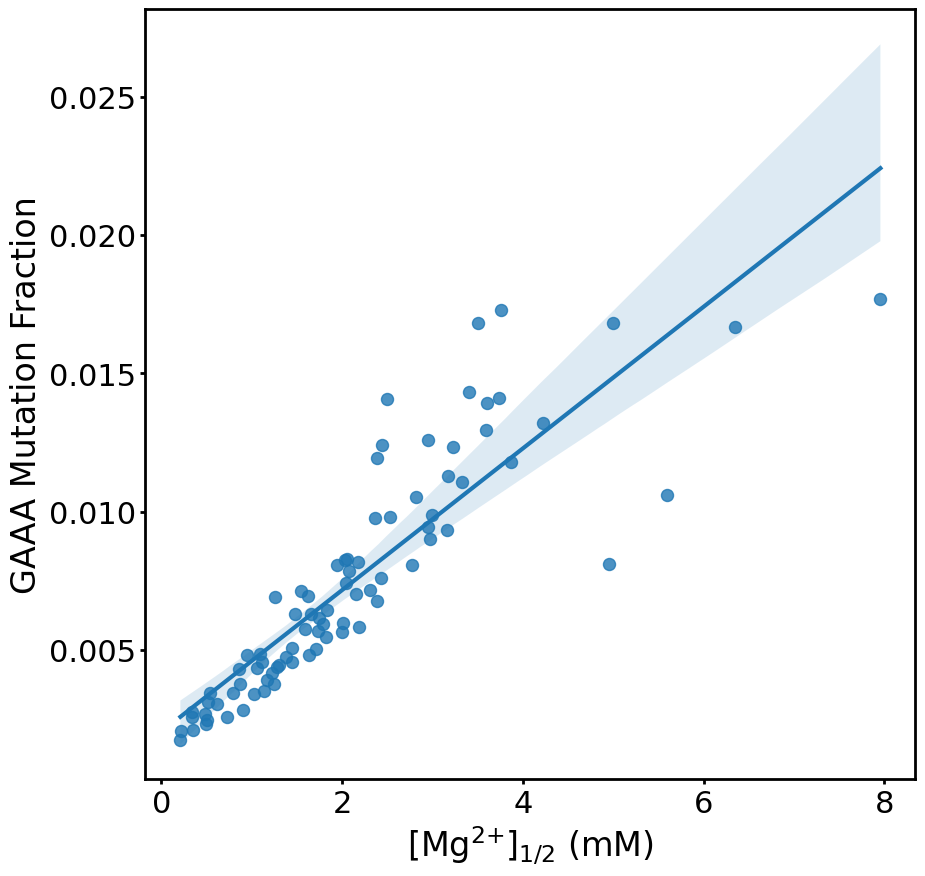

In [33]:
ax = sns.regplot(x="mg_1_2", y="gaaa_avg", data=df_sub, scatter_kws={"s": 75}, line_kws={"lw" : 3})
ax.set_box_aspect(1)
ax.set_xlabel("[Mg$^{2\!+}\!$]$_{1/2}$ (mM)")
ax.set_ylabel("GAAA Mutation Fraction")
publication_style_ax(ax)

In [34]:
r2(df_sub["mg_1_2"], df_sub["gaaa_avg"])

0.766

### Supplemental Figure XXX: ph change

Text(0, 0.5, 'pH')

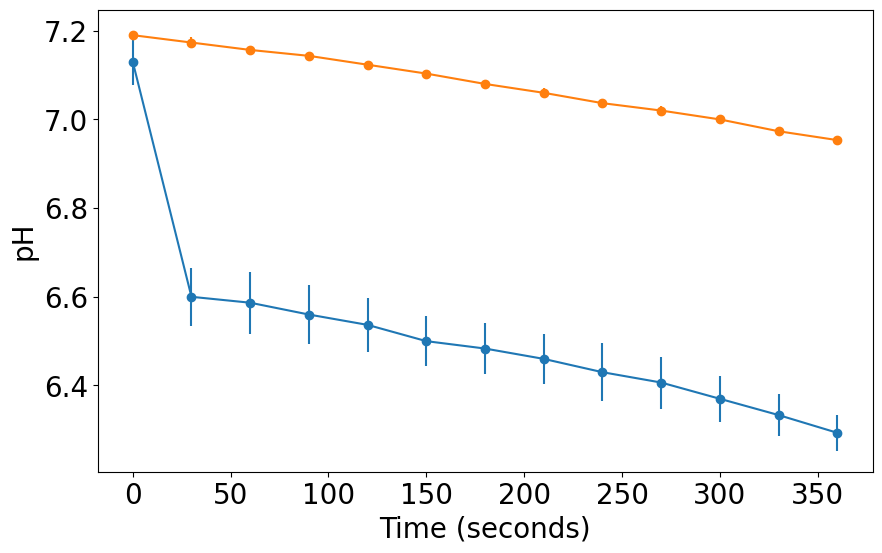

In [35]:
# Load the CSV files
file_50_mm = '../../data/ph_tests/50_mm_na_coc.csv'
file_300_mm = '../../data/ph_tests/300_mm_na_coc.csv'

data_50_mm = pd.read_csv(file_50_mm)
data_300_mm = pd.read_csv(file_300_mm)

# Calculate the average and standard deviation of pH for each time point
avg_50_mm = data_50_mm.groupby('time')['ph'].mean()
std_50_mm = data_50_mm.groupby('time')['ph'].std()

avg_300_mm = data_300_mm.groupby('time')['ph'].mean()
std_300_mm = data_300_mm.groupby('time')['ph'].std()

# Plot the data with error bars
plt.figure(figsize=(10, 6))

# Plot for 50 mM NaCOC
plt.errorbar(avg_50_mm.index, avg_50_mm, yerr=std_50_mm, label='50 mM NaCOC', fmt='-o')

# Plot for 300 mM NaCOC
plt.errorbar(avg_300_mm.index, avg_300_mm, yerr=std_300_mm, label='300 mM NaCOC', fmt='-o')

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('pH')



### Supplemental Figure XXX: different behavior of each 3 bp mutant

In [36]:
def compare_all_nuc_motifs(dfs, seq, name, ylim=0.15):
    seq = "".join(seq.split("&"))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    num_plots = sum(1 for i in range(len(seq)) if seq[i] not in ("G", "U", "&"))
    grid_size = math.ceil(math.sqrt(num_plots))
    
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(grid_size, grid_size)
    
    count = 0 
    gs = [gs[i, j] for i in range(grid_size) for j in range(grid_size)]
    
    for i in range(len(seq)):
        if seq[i] == "G" or seq[i] == "U" or seq[i] == "&":
            continue
        ax = fig.add_subplot(gs[count])
        publication_style_ax(ax)
        for j, df in enumerate(dfs):
            publication_line(ax, df['mg_conc'], df[name].apply(lambda x: x[i]), marker='o', color=colors[j])
        ax.set_title(seq[i] + str(i+1))
        ax.set_ylim([0, ylim])
        count += 1

    fig.text(0.5, 0.00, "[Mg$^{2+}$] (mM)", ha='center', va='center', size=30)
    fig.text(-0.02, 0.5, 'Mutation Fraction', ha='center', va='center', rotation='vertical', size=30)
    fig.tight_layout()

#### 3x3 motif

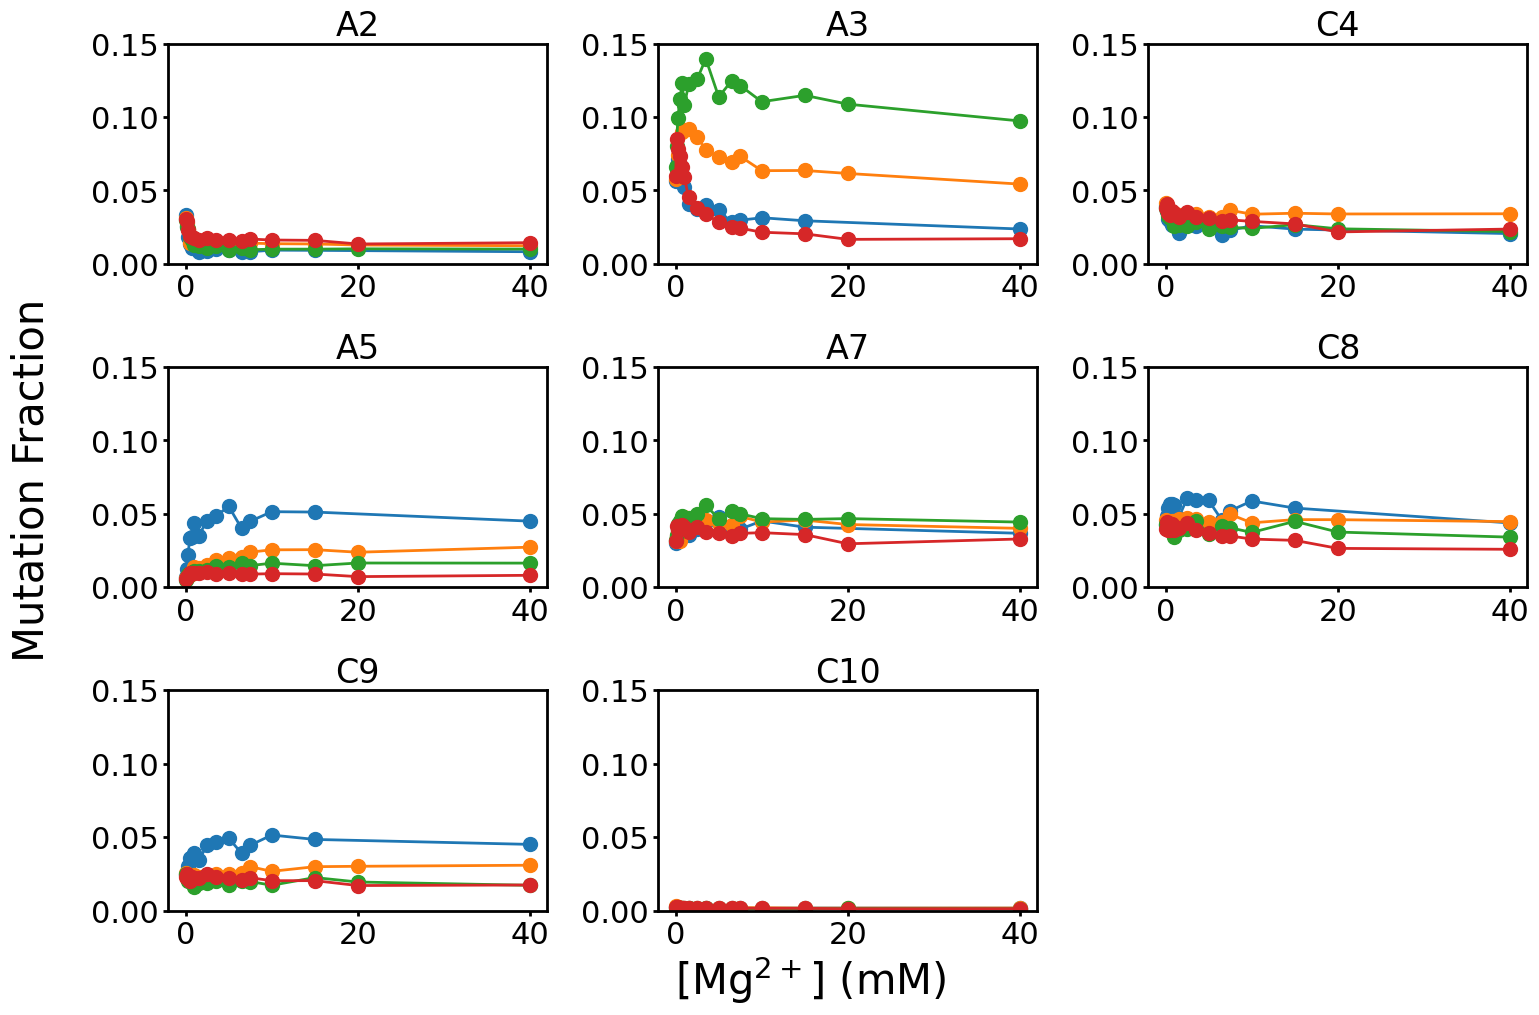

In [37]:
df_wt_1 = df_wt_mg[(df_wt_mg["buffer_conc"] == 50)]
df_h1_ins = df_mttr6_muts[(df_mttr6_muts["name"] == "minittr_6_h1_3bp_longer_fixed")]
df_h2_ins = df_mttr6_muts[(df_mttr6_muts["name"] == "minittr_6_h2_3bp_longer_fixed")]
df_h3_ins = df_mttr6_muts[(df_mttr6_muts["name"] == "minittr_6_h3_3bp_longer_fixed")]
dfs = [df_wt_1, df_h1_ins, df_h2_ins, df_h3_ins]
seq = "GAACA&UACCC"
name = "3x3_motif"
compare_all_nuc_motifs(dfs, seq, name)


#### kink turn

14


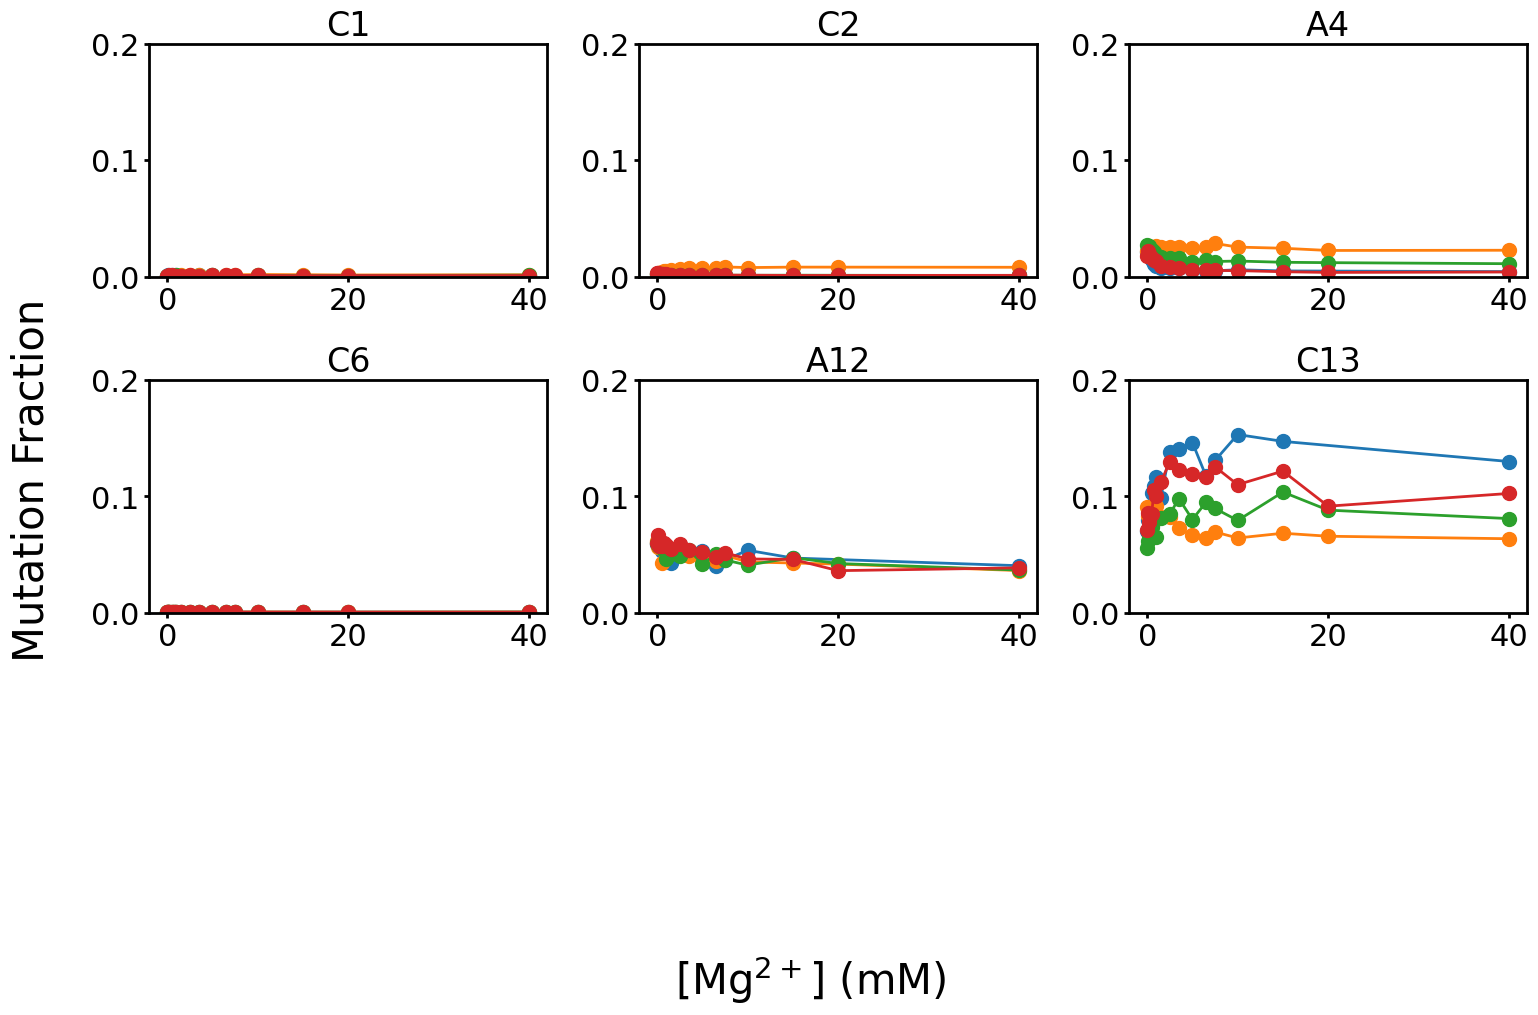

In [38]:
seq = "CCGAG&CGUUUGACG"
name = "kink_turn"
print(len(dfs[0].iloc[0][name]))
compare_all_nuc_motifs(dfs, seq, name, ylim=0.20)

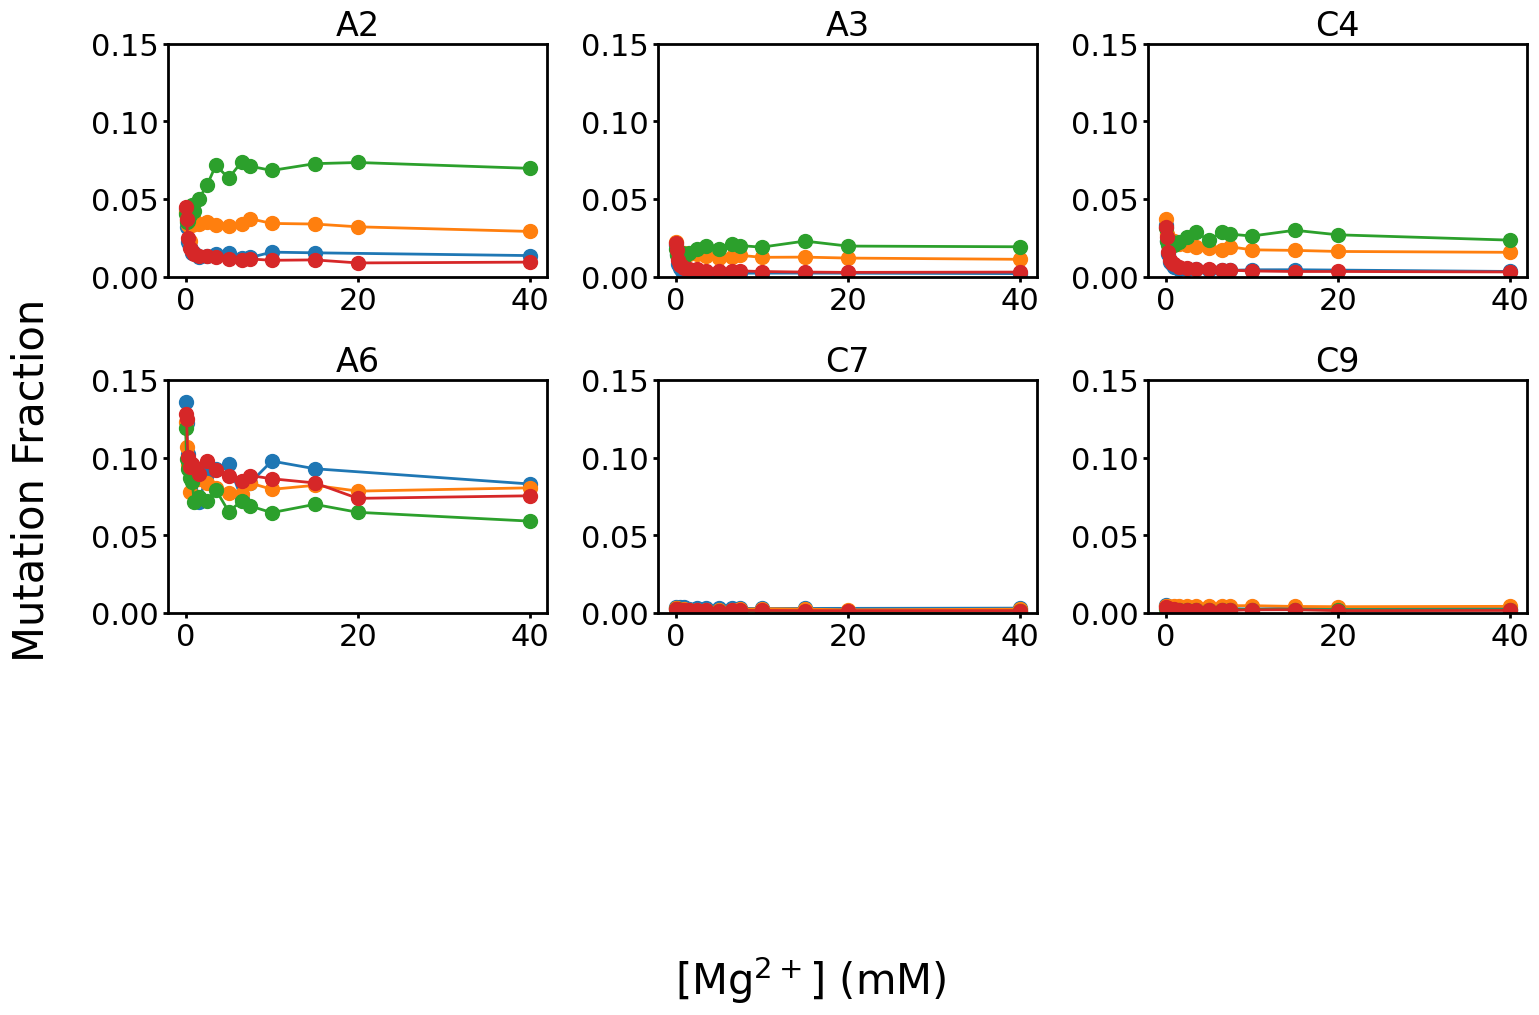

In [39]:
seq = "GAACUACGC"
name = "ires"
compare_all_nuc_motifs(dfs, seq, name)

### Supplemental Figure XXX: higharchial clustering of mutants

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/329719600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["length"] = df_sub["sequence"].apply(len)
/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


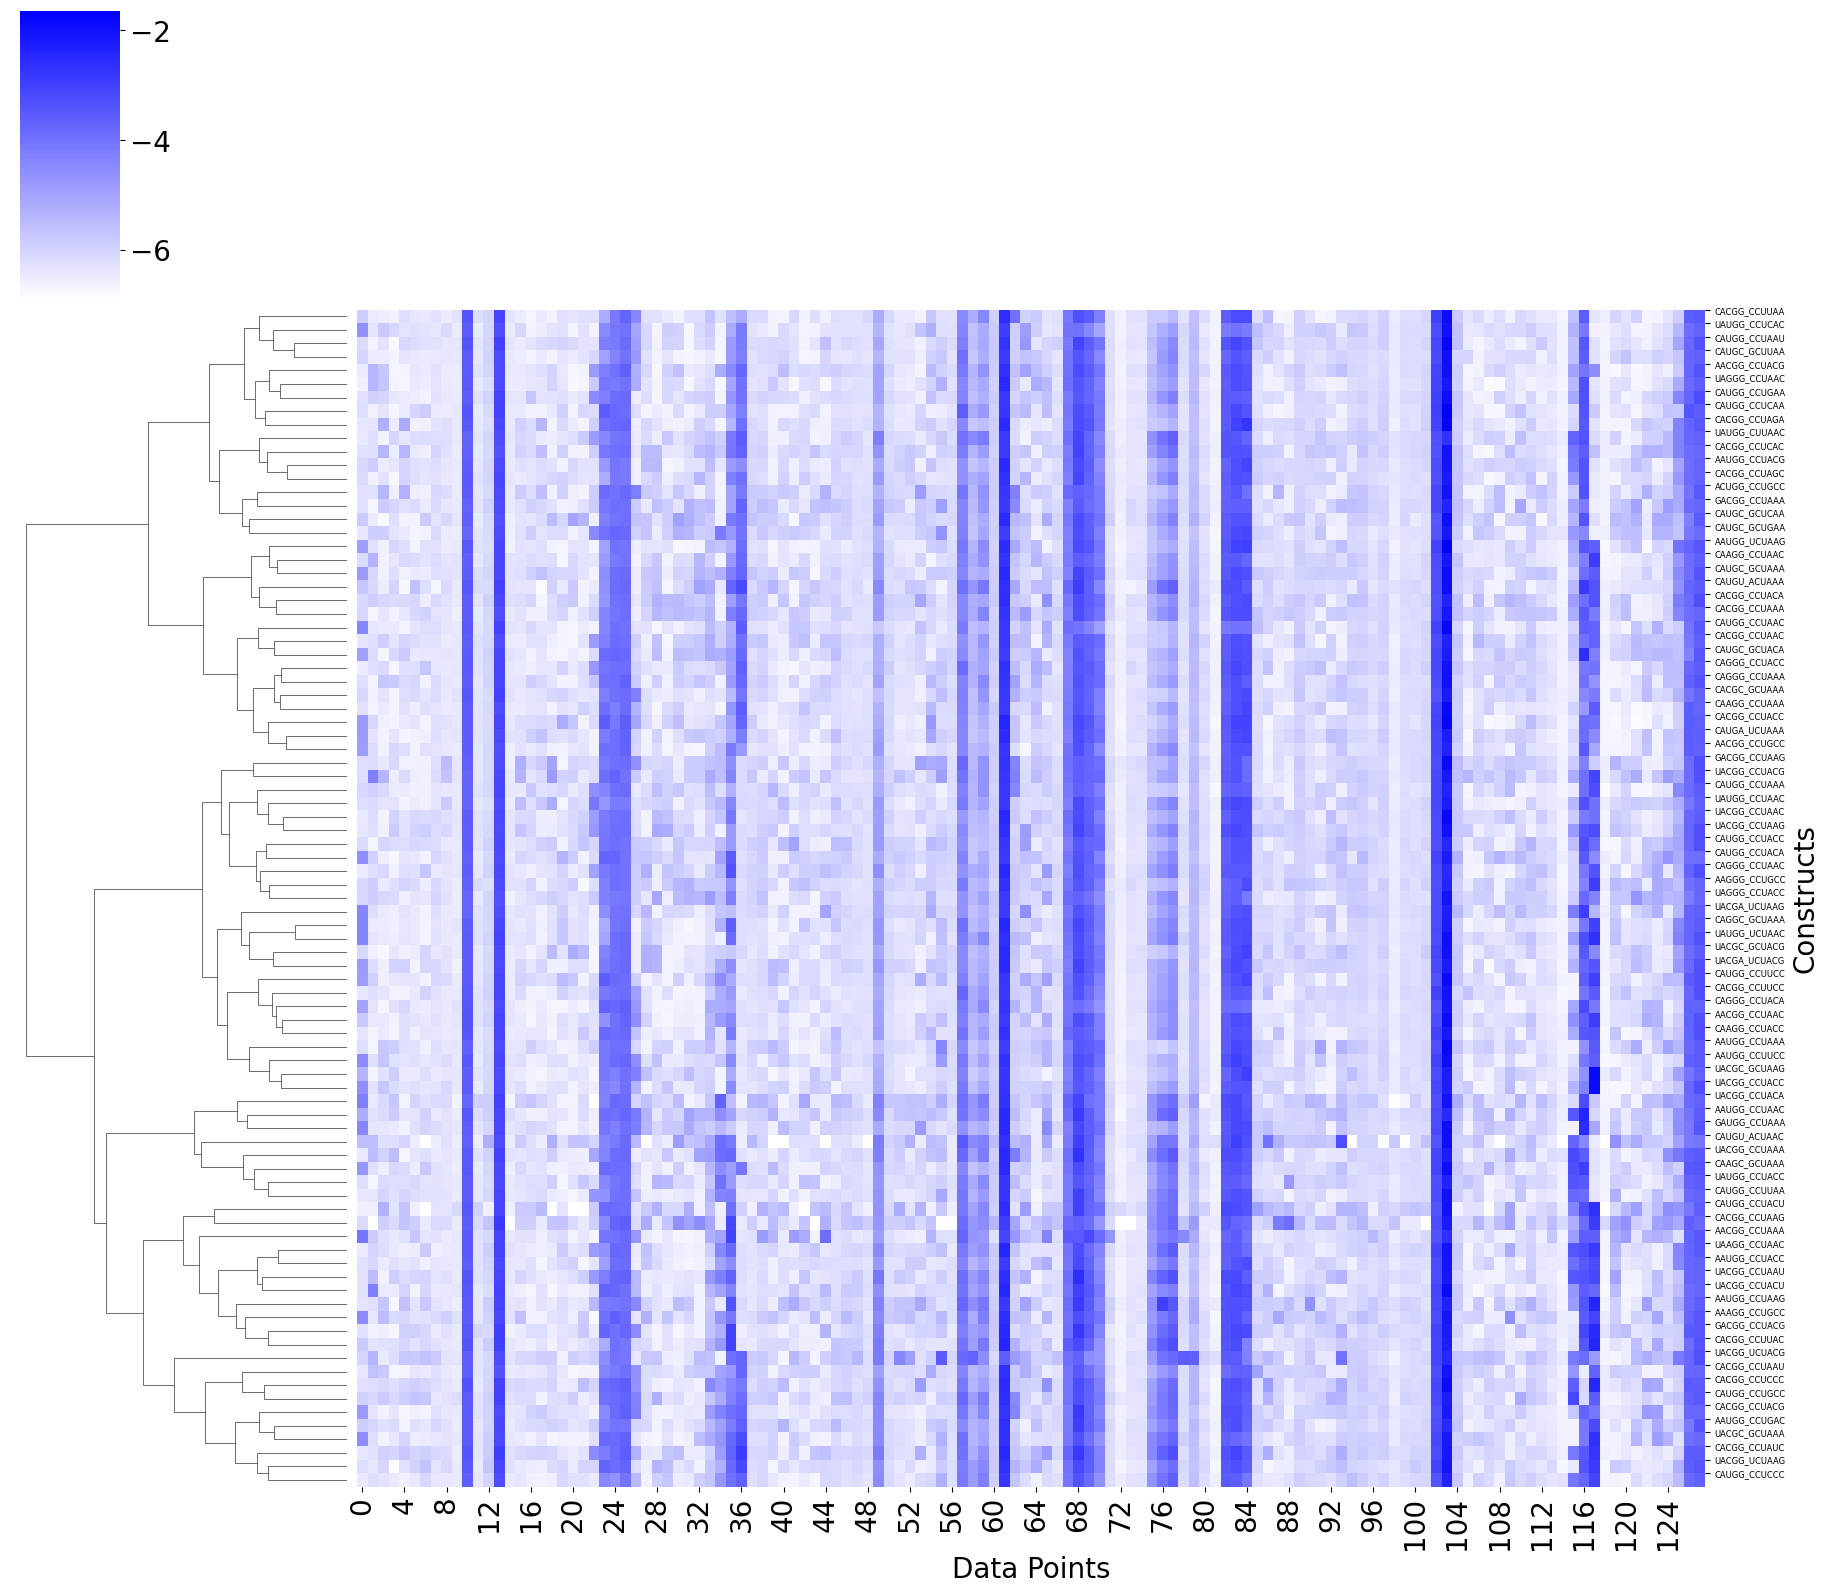

In [40]:
df_sub = df_mttr6_full[df_mttr6_full["mg_conc"] == 7.5]
df_sub["length"] = df_sub["sequence"].apply(len)
df_sub = df_sub[df_sub["length"] == 128]
df_sub["ln_data"] = [np.log([y + 0.001 for y in x]) for x in df_sub["data"]]

data_matrix = np.vstack(df_sub['ln_data'].values)
names = df_sub['name'].values

# Create a DataFrame from the data matrix for better labeling
data_df = pd.DataFrame(data_matrix, index=names)

# Create a custom colormap that transitions from white to blue
colors = [(1, 1, 1), (0, 0, 1)]  # white to blue
cmap_name = 'white_to_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a clustermap
clustermap = sns.clustermap(data_df, method='ward', cmap=cmap, figsize=(20, 16), col_cluster=False)

# Customize the plot (optional)
clustermap.ax_heatmap.set_xlabel("Data Points")
clustermap.ax_heatmap.set_ylabel("Constructs")
clustermap.ax_heatmap.set_yticks(range(0, len(data_df)), rotation=0, labels=data_df.index, size=6);


In [41]:
from scipy.cluster.hierarchy import fcluster, linkage

In [42]:
Z = linkage(data_matrix, method='ward')
max_d = 4.0  # Adjust this value based on your specific needs
clusters = fcluster(Z, max_d, criterion='distance')


In [43]:
df_sub['cluster'] = clusters

In [44]:
df_sub = df_sub.sort_values('cluster')

In [45]:
for i, group in df_sub.groupby('cluster'):
    if len(group) > 1:
        print(f"Cluster {i}: {group['name'].values}")

Cluster 1: ['UACGC_GCUACG' 'UACGG_UCUACG']
Cluster 4: ['UACGA_UCUACG' 'UACGG_CCUACG']
Cluster 8: ['UACGG_UCUAAG' 'GACGG_CCUACG']
Cluster 15: ['CAAGC_GCUAAA' 'UACGG_CCUAAC']
Cluster 17: ['UACGG_CCUACC' 'UACGC_GCUAAA']
Cluster 22: ['CAAGG_CCUAAA' 'UACGG_CCUAAA']
Cluster 23: ['CACGG_CCUAAA' 'UAAGG_CCUAAC']
Cluster 24: ['AAAGG_CCUGCC' 'CACGG_CCUACC']
Cluster 28: ['CAUGC_GCUAAA' 'UAUGG_CCUACC']
Cluster 36: ['CAGGG_CCUAAC' 'UAGGG_CCUACC']
Cluster 40: ['CAUGG_CCUACC' 'GAUGG_CCUAAA' 'AAUGG_CCUAAC']
Cluster 43: ['UAUGG_CCUAAC' 'UAUGG_UCUAAC']
Cluster 56: ['CAUGG_CCUCCC' 'CAUGG_CCUCAA']


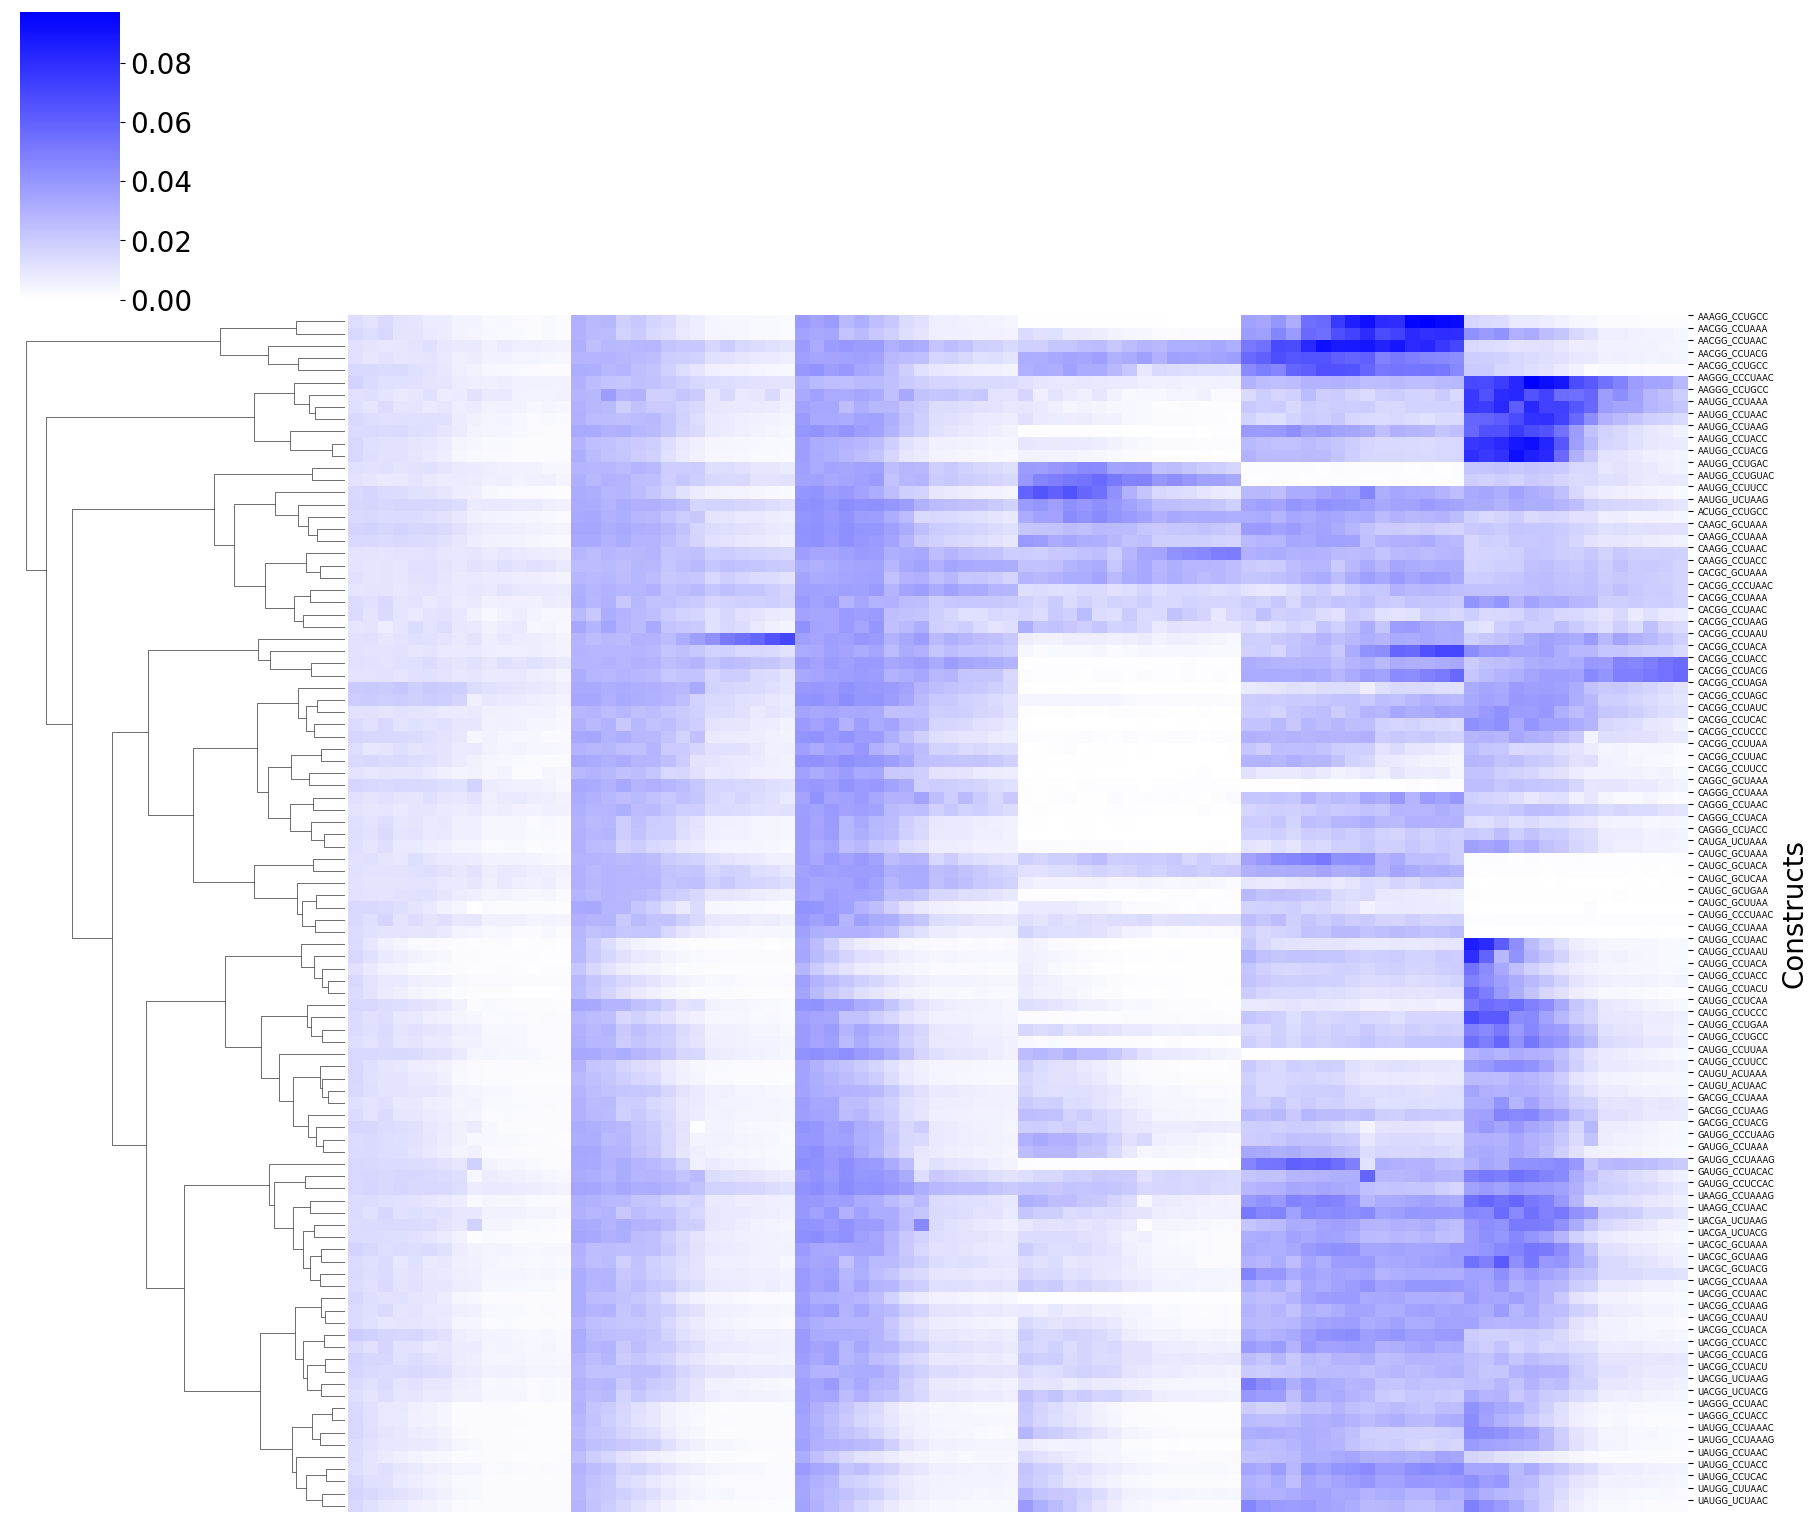

In [46]:
df_mttr6_full = df_mttr6_full[df_mttr6_full["mg_conc"] != 5.0]

names = []
all_data = []
for i, group in df_mttr6_full.groupby('name'):
    group = group.sort_values('mg_conc')
    data = []
    data.extend(group['gaaa'].apply(lambda x : x[2]))
    data.extend(group['gaaa'].apply(lambda x : x[3]))
    data.extend(group['gaaa'].apply(lambda x : x[4]))
    data.extend(group['tlr'].apply(lambda x : x[3]))
    data.extend(group['tlr'].apply(lambda x : x[4]))
    data.extend(group['tlr'].apply(lambda x : x[7]))

    names.append(i)    
    all_data.append(data)

# Create a DataFrame from the data matrix for better labeling
data_df = pd.DataFrame(all_data, index=names)

# Create a custom colormap that transitions from white to blue
colors = [(1, 1, 1), (0, 0, 1)]  # white to blue
cmap_name = 'white_to_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create a clustermap
clustermap = sns.clustermap(data_df, method='ward', cmap=cmap, figsize=(20, 16), col_cluster=False);

# Customize the plot (optional)
clustermap.ax_heatmap.set_ylabel("Constructs");
clustermap.ax_heatmap.set_xticks([]);
clustermap.ax_heatmap.set_yticks(range(0, len(data_df)), rotation=0, labels=data_df.index, size=6);

In [47]:
Z = linkage(all_data, method='ward')
max_d = 0.25  # Adjust this value based on your specific needs
clusters = fcluster(Z, max_d, criterion='distance')
data_df['cluster'] = clusters

df_sorted = data_df.sort_values(by='cluster')
data_matrix = all_data
data_df_new = pd.DataFrame(data_matrix, index=names)
data_df_sorted = data_df_new.loc[df_sorted.index]



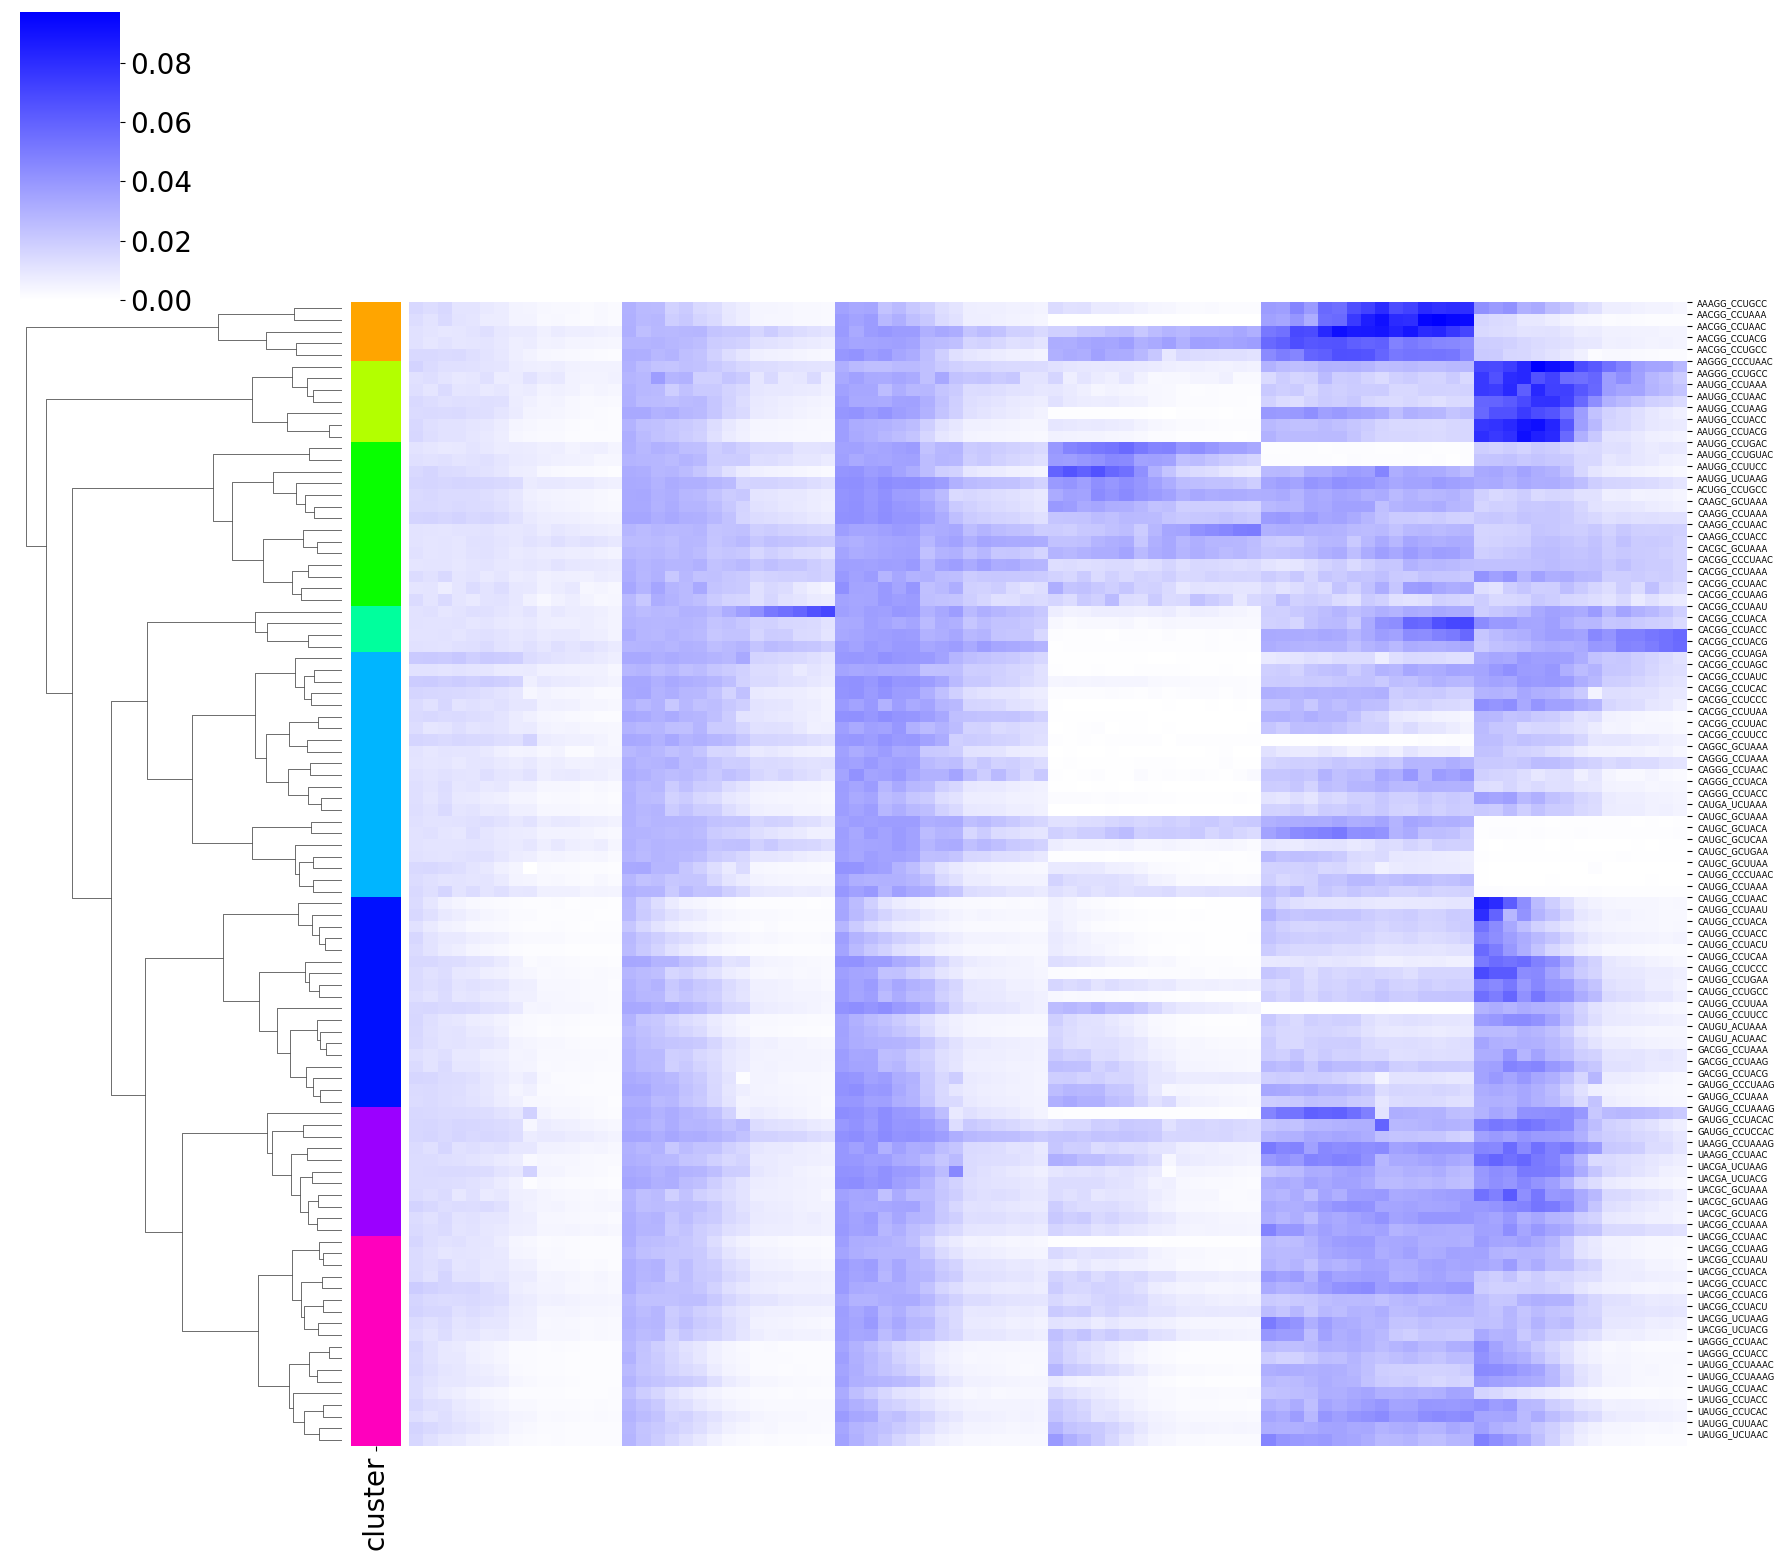

In [48]:
# Create a custom colormap that transitions from white to blue
colors = [(1, 1, 1), (0, 0, 1)]  # white to blue
cmap_name = 'white_to_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Map clusters to colors
unique_clusters = df_sorted['cluster'].unique()
cluster_palette = sns.color_palette("hsv", len(unique_clusters))
cluster_lut = dict(zip(unique_clusters, cluster_palette))
row_colors = df_sorted['cluster'].map(cluster_lut)

# Create the clustermap with the sorted DataFrame and row colors
clustermap2 = sns.clustermap(data_df_sorted, method='ward', cmap=cmap, col_cluster=False,
                            row_colors=row_colors, figsize=(20, 16))
clustermap2.ax_heatmap.set_xticks([]);
clustermap2.ax_heatmap.set_yticks(range(0, len(data_df)), rotation=0, labels=data_df.index, size=6);

In [49]:
for i, group in data_df.groupby('cluster'):
    print(i, len(group), group.index)

1 5 Index(['AACGG_CCUACG', 'AAUGG_CCUACC', 'AAUGG_CCUACG', 'AAUGG_CCUUCC',
       'CAAGG_CCUACC'],
      dtype='object')
2 7 Index(['AAAGG_CCUGCC', 'CAGGC_GCUAAA', 'CAGGG_CCUAAC', 'CAUGA_UCUAAA',
       'CAUGC_GCUAAA', 'CAUGU_ACUAAA', 'UAGGG_CCUAAC'],
      dtype='object')
3 14 Index(['AAUGG_CCUAAG', 'AAUGG_UCUAAG', 'CACGG_CCUAAG', 'CACGG_CCUAGA',
       'CACGG_CCUAGC', 'CACGG_CCUCAC', 'CAUGC_GCUCAA', 'CAUGG_CCUAAU',
       'CAUGG_CCUACU', 'CAUGG_CCUCAA', 'CAUGG_CCUCCC', 'GACGG_CCUACG',
       'UACGG_CCUACA', 'UAUGG_CCUCAC'],
      dtype='object')
4 4 Index(['CAUGC_GCUGAA', 'CAUGG_CCUGAA', 'GACGG_CCUAAA', 'UAUGG_CUUAAC'], dtype='object')
5 21 Index(['AACGG_CCUAAA', 'AAGGG_CCCUAAC', 'AAUGG_CCUGUAC', 'ACUGG_CCUGCC',
       'CACGG_CCCUAAC', 'CACGG_CCUUAA', 'CACGG_CCUUAC', 'CACGG_CCUUCC',
       'CAUGC_GCUUAA', 'CAUGG_CCCUAAC', 'CAUGG_CCUGCC', 'CAUGG_CCUUAA',
       'CAUGG_CCUUCC', 'GAUGG_CCCUAAG', 'GAUGG_CCUAAAG', 'GAUGG_CCUACAC',
       'GAUGG_CCUCCAC', 'UAAGG_CCUAAAG', 'UACGG_CCUAAA', '

<Axes: xlabel='cluster', ylabel='mg_1_2'>

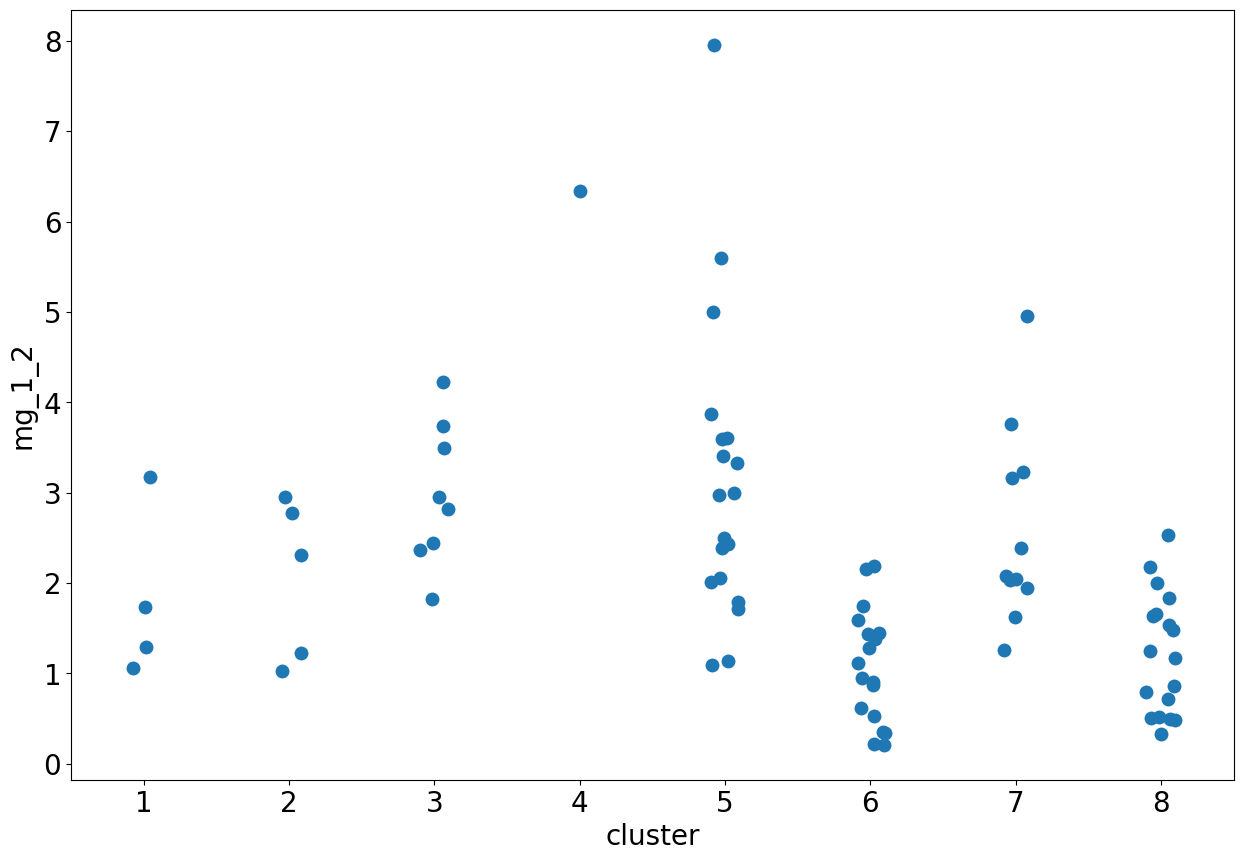

In [66]:
df_sub = df_mg_1_2[~df_mg_1_2["name"].isin(exclude)].copy()
df_sub = df_sub.merge(df_dg, on="name")
data_df_name = data_df.copy()
data_df_name["name"] = data_df_name.index
df_sub = df_sub.merge(data_df_name[["name", "cluster"]], on="name")
df_sub = df_sub[df_sub["mg_1_2"] < 10]
sns.categorical.stripplot(x='cluster', y='mg_1_2', data=df_sub, size=10)

In [51]:
def plot_sequences_by_mutation(wt_seq, mut_seqs, figsize=(2, 1.5)):
    
    # Define the mutation colors
    color_mapping = {
        'A': 'red',
        'C': 'blue',
        'G': 'yellow',
        'T': 'green',
        'U': 'green'
    }
    # Prepare a DataFrame to hold the sequences
    df = pd.DataFrame(mut_seqs, columns=['sequence'])
    df['sequence'] = df['sequence'].apply(list)
    sequence_length = len(wt_seq)

    # Create a matrix for the heatmap
    heatmap_data = np.empty((len(mut_seqs), sequence_length), dtype=object)
    for i, seq in enumerate(mut_seqs):
        for j, (wt_char, seq_char) in enumerate(zip(wt_seq, seq)):
            if wt_char == seq_char:
                heatmap_data[i, j] = wt_char
            else:
                heatmap_data[i, j] = seq_char
    # Convert the matrix to a DataFrame
    heatmap_df = pd.DataFrame(heatmap_data, columns=list(wt_seq))
    # Create a custom colormap
    custom_cmap = ListedColormap(['white', 'red', 'blue', 'yellow', 'green'])

    # Create a color matrix for the heatmap
    color_matrix = np.empty((len(mut_seqs), sequence_length), dtype=object)
    for i in range(len(mut_seqs)):
        for j in range(sequence_length):
            if heatmap_data[i, j] == wt_seq[j]:
                color_matrix[i, j] = 'white'
            else:
                color_matrix[i, j] = color_mapping[heatmap_data[i, j]]

    # Plot the heatmap 
    plt.figure(figsize=figsize)  # Adjust figsize to shrink the boxes
    ax = sns.heatmap(np.zeros_like(heatmap_df, dtype=float), annot=heatmap_data, fmt='', 
                     cmap=custom_cmap, cbar=False, linewidths=0.5, linecolor='black',
                    annot_kws={"size": 14})
    for i in range(len(mut_seqs)):
        for j in range(sequence_length):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))

    # Customize the plot
    #ax.set_xticks(np.arange(sequence_length) + 0.5)
    #ax.set_xticklabels(list(wt_seq), rotation=90, fontsize=8)
    #ax.set_yticks(np.arange(len(mut_seqs)) + 0.5)
    #ax.set_yticklabels([f"Seq {i+1}" for i in range(len(mut_seqs))], rotation=0, fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.xlabel("Position", fontsize=10)
    plt.ylabel("Sequence", fontsize=10)



/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


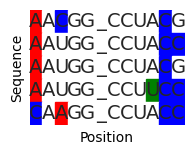

In [53]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUACG', 'AAUGG_CCUACC', 'AAUGG_CCUACG', 'AAUGG_CCUUCC',
       'CAAGG_CCUACC']
plot_sequences_by_mutation(wt_seq, cluster_seqs)


/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


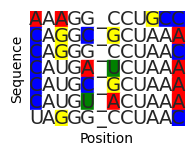

In [54]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AAAGG_CCUGCC', 'CAGGC_GCUAAA', 'CAGGG_CCUAAC', 'CAUGA_UCUAAA',
       'CAUGC_GCUAAA', 'CAUGU_ACUAAA', 'UAGGG_CCUAAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs)

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


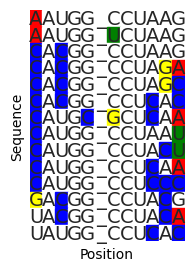

In [55]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AAUGG_CCUAAG', 'AAUGG_UCUAAG', 'CACGG_CCUAAG', 'CACGG_CCUAGA',
       'CACGG_CCUAGC', 'CACGG_CCUCAC', 'CAUGC_GCUCAA', 'CAUGG_CCUAAU',
       'CAUGG_CCUACU', 'CAUGG_CCUCAA', 'CAUGG_CCUCCC', 'GACGG_CCUACG',
       'UACGG_CCUACA', 'UAUGG_CCUCAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 3))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


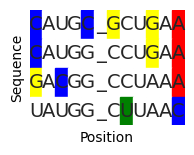

In [56]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['CAUGC_GCUGAA', 'CAUGG_CCUGAA', 'GACGG_CCUAAA', 'UAUGG_CUUAAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs)

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


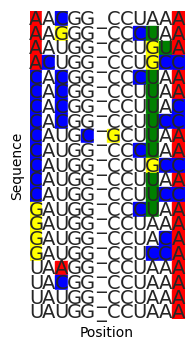

In [57]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUAAA', 'AAGGG_CCCUAAC', 'AAUGG_CCUGUAC', 'ACUGG_CCUGCC',
       'CACGG_CCCUAAC', 'CACGG_CCUUAA', 'CACGG_CCUUAC', 'CACGG_CCUUCC',
       'CAUGC_GCUUAA', 'CAUGG_CCCUAAC', 'CAUGG_CCUGCC', 'CAUGG_CCUUAA',
       'CAUGG_CCUUCC', 'GAUGG_CCCUAAG', 'GAUGG_CCUAAAG', 'GAUGG_CCUACAC',
       'GAUGG_CCUCCAC', 'UAAGG_CCUAAAG', 'UACGG_CCUAAA', 'UAUGG_CCUAAAC',
       'UAUGG_CCUAAAG']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 4))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


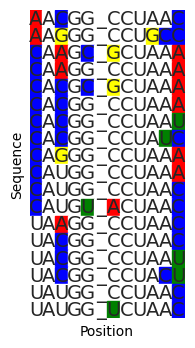

In [58]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUAAC', 'AAGGG_CCUGCC', 'CAAGC_GCUAAA', 'CAAGG_CCUAAA',
       'CACGC_GCUAAA', 'CACGG_CCUAAA', 'CACGG_CCUAAU', 'CACGG_CCUAUC',
       'CAGGG_CCUAAA', 'CAUGG_CCUAAA', 'CAUGG_CCUAAC', 'CAUGU_ACUAAC',
       'UAAGG_CCUAAC', 'UACGG_CCUAAC', 'UACGG_CCUAAU', 'UACGG_CCUACU',
       'UAUGG_CCUAAC', 'UAUGG_UCUAAC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 4))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


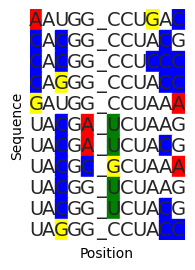

In [59]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AAUGG_CCUGAC', 'CACGG_CCUACG', 'CACGG_CCUCCC', 'CAGGG_CCUACC',
       'GAUGG_CCUAAA', 'UACGA_UCUAAG', 'UACGA_UCUACG', 'UACGC_GCUAAA',
       'UACGG_UCUAAG', 'UACGG_UCUACG', 'UAGGG_CCUACC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 3))

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_58870/3388360874.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=color_matrix[i, j], edgecolor='black'))


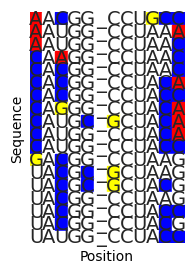

In [60]:
wt_seq = "UAUGG_CCUAAG"
cluster_seqs = ['AACGG_CCUGCC', 'AAUGG_CCUAAA', 'AAUGG_CCUAAC', 'CAAGG_CCUAAC',
       'CACGG_CCUAAC', 'CACGG_CCUACA', 'CACGG_CCUACC', 'CAGGG_CCUACA',
       'CAUGC_GCUACA', 'CAUGG_CCUACA', 'CAUGG_CCUACC', 'GACGG_CCUAAG',
       'UACGC_GCUAAG', 'UACGC_GCUACG', 'UACGG_CCUAAG', 'UACGG_CCUACC',
       'UACGG_CCUACG', 'UAUGG_CCUACC']
plot_sequences_by_mutation(wt_seq, cluster_seqs, figsize=(2, 3))

### supplemental figure: wild type reactivity change

In [61]:
df_sub = df_wt_mg.query('buffer_conc == 50 and mg_conc == 0')


In [62]:
ss = SequenceStructure("GAUAUGG&CCUAAGUC", "(((..((&))...)))")


In [63]:
data_m_0 = get_dms_reactivity_for_sub_structure(df_sub, ss)
full_data_m_0 = df_sub['gaaa'].iloc[0] + data_m_0[0]
generate_pymol_file(full_data_m_0, "wt_mg_0.dat")


In [64]:
df_sub = df_wt_mg.query('buffer_conc == 50 and mg_conc == 40')


In [65]:
data_m_40 = get_dms_reactivity_for_sub_structure(df_sub, ss)
full_data_m_0 = df_sub['gaaa'].iloc[0] + data_m_40[0]
generate_pymol_file(full_data_m_0, "wt_mg_40.dat")
